<a href="https://colab.research.google.com/github/FredLongo/MLDL_Project/blob/main/LSTM_Team_Project_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM Team Project
## By changes parameter setting you create, train and predict an array of model to predict stocks.



#Code Section

In [ ]:
pip install pandas_ta

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import pandas_ta as ta
from sklearn.preprocessing import MinMaxScaler
import warnings
from datetime import datetime, timedelta


"""#Now build the model"""
from re import VERBOSE
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed

import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate

""" performance evaluation """
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import math
import csv
pd.set_option('display.max_columns', None)




In [ ]:
class MyLSTMModel:
    def __init__(self, indicators='^DJI',
                 ticker='ADM',
                 frame_days=10,
                 lstm_layers = 1,
                 start_date = '2012-03-11',
                 end_date='2022-07-10',
                 batch_size=15,
                 epochs=30,
                 run = False,
                 run_all=False,
                 verbose=1,
                 name=''):
        #Parameters
        self.name           = name
        self.indicators     = indicators
        self.ticker         = ticker
        self.run            = run
        self.run_all        = run_all
        #Data Setup
        self.start_date     = start_date
        self.end_date       = end_date
        self.frame_days     = frame_days
        self.ticker_list    = indicators + ',' +ticker
        self.ticker_list_ct  = len(self.ticker_list.split(','))
        self.tickers        = self.ticker_list.split(',')
        self.data = pd.DataFrame()
        #Model Setup
        self.model          = None
        self.lstm_layers    = lstm_layers
        self.lstm_nodes     = 0
        self.batch_size     = batch_size
        self.epochs         = epochs
        self.verbose        = verbose
        #Report
        self.pred_diff    = np.array([])
        self.pred_diff_bias  = np.array([])
        self.pred_correctness = np.array([])
        self.pred_correctness_mean = np.array([])
        self.history = np.array([])
        self.fitting_elapse_time = None
        self.root_mean_sqr_err = 0
        #Misc
        self.data_set = pd.DataFrame()
        self.data_set_scaled = np.array([])
        self.X        = np.array([])              # X[Column][Sample][Frame_day]
        self.X_train  = np.array([])
        self.X_test   = np.array([])
        self.y_train  = np.array([])
        self.y_test   = np.array([])
        self.y_pred   = np.array([])

        if self.name == '':
          self.name = ticker + '_F' + str(frame_days) + '_L' + str(lstm_layers)

        if self.run or self.run_all:
          self.Run()



    def Data__LoadAndPrep(self):
        #Download Data from Yahoo Finance
        self.data = yf.download(tickers=self.tickers, start=self.start_date, end=self.end_date)

        # Add all additional indicators
        for (_type, _ticker) in self.data.columns:
          if _type == 'Close':
            rsi_values = ta.rsi(self.data[(_type, _ticker)], length=15)
            self.data[('RSI', _ticker)] = rsi_values
            emaf_values = ta.rsi(self.data[(_type, _ticker)], length=20)
            self.data[('EMAF', _ticker)] = rsi_values
            emam_values = ta.rsi(self.data[(_type, _ticker)], length=100)
            self.data[('EMAM', _ticker)] = rsi_values
            emas_values = ta.rsi(self.data[(_type, _ticker)], length=150)
            self.data[('EMAS', _ticker)] = rsi_values

        # Add the Training an validation column info.
        self.data[('Target',self.ticker)] = self.data['Adj Close',self.ticker]-self.data['Open',self.ticker]                                # 1) Diff of current open and future close
        self.data[('Target',self.ticker)] = self.data['Target',self.ticker].shift(-1)                                                       #
        self.data[('TargetClass',self.ticker)] = [1 if self.data[('Target',self.ticker)][i]>0 else 0 for i in range(len(self.data))]        # 2) Classificaton approche 1= up 0 = down.
        self.data[('TargetNextClose',self.ticker)] = self.data[('Adj Close',self.ticker)].shift(-1)                                         # 3) Closing Price of the next day

        #Remove unused columns
        self.data.dropna(inplace=True)                                                       # Dropping values not their
        self.data.reset_index(inplace = True)                                                # rebuild index after removed values

        with warnings.catch_warnings():
          warnings.simplefilter("ignore", category=pd.errors.PerformanceWarning)
          self.data.drop([('Close', self.ticker)], axis=1, inplace=True)                       # Removing because we are going with Adjuested Close
          self.data.drop(['Date'], axis=1, inplace=True)                                       # Removing unsued Columns  (R1)


    def Data_Set__LoadAndPrep(self):
        self.data_set = self.data.iloc[:,0:len(self.data.columns)]#.values
        # Scale the dataset
        sc = MinMaxScaler(feature_range=(0,1))             # Apply Scaler to oour data to make it between 0 and `
        self.data_set_scaled = sc.fit_transform(self.data_set)


    def Data_Prep_Input(self):
        # Create frame of given candles
        self.X = []

        for j in range(len(self.data_set.columns) -1):#data_set_scaled[0].size):#2 columns are target not X         # Removing some of the columns  Adding volume
            self.X.append([])
            for i in range(self.frame_days, self.data_set_scaled.shape[0]):#framedays+2
                self.X[j].append(self.data_set_scaled[i-self.frame_days:i, j])

        #Swith Order, move axis from 0 to last position 2                               # Moves  X[Column][Sample][Frame_day]
                                                                                        #   to   X[Sample][Frame_day][Column]
        self.X = np.moveaxis( self.X, [0], [2])


        # Choose -1 for last column, classification else -2...
        self.X, yi =np.array(self.X), np.array(self.data_set_scaled[self.frame_days:,-1])
        y=np.reshape(yi,(len(yi),1))

        # split data into train test sets
        splitlimit = int(len(self.X)*0.8)          #point to slit at
        self.X_train, self.X_test = self.X[:splitlimit], self.X[splitlimit:]
        self.y_train, self.y_test = y[:splitlimit], y[splitlimit:]

        ############################################################
        ##   Build Model
        ############################################################
    def Build_Model(self):
        self.lstm_nodes = len(self.X[0][0])
        lstm_input = Input(shape=(self.frame_days, self.lstm_nodes), name='lstm_input')      # Input layer
        current_inputs = lstm_input  # first time needs to be input layer (lstm_input) after that (inputs)
        for l in reversed(range(self.lstm_layers)):
          layer_name = f'lstm_layer_{self.lstm_layers - l}'
          if 0 != l:
            inputs = LSTM(self.lstm_nodes, return_sequences=True, name=layer_name)(current_inputs)
          else:
            inputs = LSTM(self.lstm_nodes, name=layer_name)(current_inputs)
          current_inputs = inputs
        inputs = Dense(1, name='dense_layer')(inputs)                                          # One Dense Layer
        output = Activation('linear', name='output')(inputs)                                   # Output layer
        self.model = Model(inputs=lstm_input, outputs=output)                                  # declare model
        adam = optimizers.Adam()                                                               # instanciate optimizer
        self.model.compile(optimizer=adam, loss='mse', metrics=['mae'])
#        print(f'Model Layers:')                      # Compile model
#        for ml in self.model.layers:
#            print(ml.name)

    def Fit(self):
        start_time = datetime.now()
        print(f'___________{self.name}___________')
        print(f'Start Time:{start_time}')
        self.history = self.model.fit(x=self.X_train,
                       y=self.y_train,
                       batch_size=self.batch_size,
                       epochs=self.epochs, #TODO Set back to 30
                       shuffle=False,
                       validation_data=(self.X_test, self.y_test),
                       verbose=self.verbose)
        end_time = datetime.now()
        self.fitting_elapse_time = end_time - start_time
        print(f'End Time:{end_time}')
        print(f'Elapse Time:{self.fitting_elapse_time}')


    def Predict(self):
      self.y_pred = self.model.predict(self.X_test)

        ############################################################
        ### Evaluation and reports
        ############################################################
    def check_sign(self,number):
        if number > 0:
            return 1
        elif number < 0:
            return -1
        else:
            return 0


     # X_test = Open,	High,	Low,	Adj Close,	Volume,	RSI	EMAF,	EMAM,	EMAS,

    def Get_diffs(self):
        _size = self.y_test.shape[0]
        self.pred_correctness   = np.zeros(_size)
        self.pred_diff          = np.zeros(_size)
        self.pred_diff_bias      = np.zeros(_size)

        for i in range(_size):                                 # X[Sample][Frame_day][column]
          Opening    =  self.X_test[i][0][(self.ticker_list_ct * 4) -1]                        # Opening column for ticker is always (ticker_count * 4 -1)
          Actual     =  self.y_test[i]
          Predicted  =  self.y_pred[i]
          with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=DeprecationWarning)
            self.pred_diff[i]    = Predicted/Actual
            self.pred_diff_bias[i]  = 1 - (Predicted/Actual)
            if self.check_sign(Opening - Actual) == self.check_sign(Opening - Predicted):
              self.pred_correctness[i] = True;                                  #It predicted Correct!
            else: self.pred_correctness[i] = False;                             #It did predict correctly


                #Mean Squre Error
        self.mean_sqr_err =  mean_squared_error(self.y_test, self.y_pred)

        # Mean absolute Error
        self.mean_abs_err = mean_absolute_error(self.y_test, self.y_pred)

        self.pred_correctness_mean = self.pred_correctness.mean()
        self.pred_diff_mean = self.pred_diff.mean()
        self.pred_diff_bias_mean  = self.pred_diff_bias.mean()

         # R^2    = ?????


    def View_Performance_Report(self,show_graphs=True, show_report=True , graphs=[]):


        # Root Mean Squred Error.
        self.root_mean_sqr_err = math.sqrt(self.mean_sqr_err)
        print("############################################################################")
        print("  Model Setup:")
        print(f"                    Name: {self.name}")
        print(f"             LSTM_Layers: {self.lstm_layers}")
        print(f"              LSTM_Nodes: {self.lstm_nodes}")
        print(f"               Bach_Size: {self.batch_size}")
        print(f"                  Epochs: {self.epochs}")
        print("  Data Setup:")
        print(f"                  Ticker: {self.ticker}")
        print(f"             Indicattors: {self.indicators}")
        print(f"              Start_Date: {self.start_date}")
        print(f"                End_Date: {self.end_date}")
        print(f"              Frame_Days: {self.frame_days}")
        print("  Result Data:")
        print(f'             mean_abs_err ={self.mean_abs_err}')
        print(f'             mean_sqr_err ={self.mean_sqr_err}')
        print(f'        root_mean_sqr_err ={self.root_mean_sqr_err}')
        print(f'           pred_diff_mean ={self.pred_diff_mean}')
        print(f'      pred_diff_bias_mean ={self.pred_diff_bias_mean}')
        print(f'    pred_correctness_mean ={self.pred_correctness_mean}')
        print("")

        #Plot Graph



        if  ('Eval_Loss' in graphs) or (show_graphs == True) :  # ('Pie' in show_graphs:)

          plt.figure(figsize=(12, 6))
          plt.subplot(1, 2, 1)
          plt.plot(self.history.history['mae'])
          plt.plot(self.history.history['val_mae'])
          plt.title('Evaluation Metric - Mean Absolute Error (MAE)')
          plt.ylabel('MAE')
          plt.xlabel('Epoch')
          plt.legend(['Train', 'Validation'], loc='upper left')


          # Plot training & validation loss values
          plt.subplot(1, 2, 2)
          plt.plot(self.history.history['loss'])
          plt.plot(self.history.history['val_loss'])
          plt.title('Model Loss - Mean Sqr Error (MSE) ')
          plt.ylabel('Loss')
          plt.xlabel('Epoch')
          plt.legend(['Train', 'Validation'], loc='upper left')
          plt.show()

        if  ('TrainingMAE' in graphs) or (show_graphs == True) :
          #####Break Down
          plt.figure(figsize=(12, 6))

          #plt.subplot(1, 1, 1)
          plt.plot(self.history.history['mae'])
          plt.title('Training Mean Absolute Error')
          plt.ylabel('MAE')
          plt.xlabel('Epoch')
          plt.legend(['Train'], loc='upper left')
          plt.show()


        if  ('ActVsPed_Line' in graphs) or (show_graphs == True) :  # ('Pie' in show_graphs:)
          # Actual vs Predicted Chart
          plt.figure(figsize=(16,8))
          plt.title('Actual Vs Prediction Results')
          plt.plot(self.y_test, color = 'black', label = 'Test')
          plt.plot(self.y_pred, color = 'green', label = 'pred')
          plt.legend()
          plt.show()

        if  ('ActVsPed_Pie' in graphs) or (show_graphs == True) :  # ('Pie' in show_graphs:)
          # Pie Chart
          values = [self.pred_correctness_mean, 1 - self.pred_correctness_mean ]
          labels = [f'Correctly Predicted {self.pred_correctness_mean:.2f}%', f'Incorect{1 - self.pred_correctness_mean:.2f}%']
          colors = ['g','r']
          explode = [0.1, 0]
          plt.title(f'Correct Prediction " {self.pred_correctness_mean:.2f}%  "of the time')
          plt.pie(values, labels=labels, colors=colors, explode=explode)
          plt.show




    def Run(self):
      self.Data__LoadAndPrep()
      self.Data_Set__LoadAndPrep()
      self.Data_Prep_Input()
      self.Build_Model()
      self.Fit()
      self.Predict()
      self.Get_diffs()
      if self.run_all == True:
        self.View_Performance_Report()









In [ ]:
def SaveDataToCSV(_model_list,_ticker_symble):
  # Specify the CSV file name
  current_datetime = datetime.now().strftime("%Y%m%d_%H%M%S")
  filename = f'/content/drive/MyDrive/Classes/Kent/Machine Learning/Results/{_ticker_symble}_Results_{current_datetime}.csv'

  # Field names in the CSV file
  fields = ['ModelName','Layers','Batch_Size', 'Epoch','Ticker','Indicattors','Frame_Days','mean_abs_err','mean_sqr_err','root_mean_sqr_err','pred_diff_mean','pred_diff_bias_mean',"elapsTime"]

  # Writing to the csv file
  with open(filename, mode='w', newline='') as file:
      writer = csv.DictWriter(file, fieldnames=fields)

      # Writing headers (field names)
      writer.writeheader()

      # Writing data of each object
      for m in _model_list:
          writer.writerow({'ModelName': m.name,
                           'Layers':m.lstm_layers,
                           'Batch_Size': m.batch_size,
                           'Epoch':m.epochs,
                           'Ticker':m.ticker,
                           'Indicattors':m.indicators,
                           'Frame_Days':m.frame_days,
                           'mean_abs_err':m.mean_abs_err,
                           'mean_sqr_err':m.mean_sqr_err,
                           'root_mean_sqr_err':m.root_mean_sqr_err,
                           'pred_diff_mean':m.pred_diff_mean,
                           'pred_diff_bias_mean':m.pred_diff_bias_mean,
                           "elapsTime":m.fitting_elapse_time })


# Get Fields








# Model Fit Section

# Model Training

In [ ]:
Indicators    = '^DJI,^BSESN,^BVSP'
Ticker = ['ADM','MSI','XOM']
frame_days = [10,25,50,75,100]
LSTM_layers = [1,2,3,4,5,6]


Number_of_Models_to_Test = len(Ticker) * len(frame_days) *  len(LSTM_layers)

print(f'Testing {Number_of_Models_to_Test} models')


Testing 20 models


In [ ]:


for t in Ticker:
  model_list = []
  for f in frame_days:
    for l in LSTM_layers:
      new_model = MyLSTMModel(indicators= Indicators,
                              ticker=t,
                              frame_days=f,
                              lstm_layers=l,
                              verbose=2,
                              run=True)
      model_list.append(new_model)

  #Best_Model = max(model_list, key=lambda m:m.pred_diff_mean)
  #print(f"Best Model is {Best_Model.name} with {Best_Model.pred_diff_mean:.2f}%  !!!")
  SaveDataToCSV(model_list,t)



[*********************100%%**********************]  4 of 4 completed


___________MSI_F10_L1___________
Start Time:2024-04-30 15:15:51.405173
Epoch 1/30
122/122 - 8s - loss: 0.0029 - mae: 0.0420 - val_loss: 0.0355 - val_mae: 0.1602 - 8s/epoch - 66ms/step
Epoch 2/30
122/122 - 1s - loss: 0.0025 - mae: 0.0391 - val_loss: 0.0401 - val_mae: 0.1695 - 1s/epoch - 10ms/step
Epoch 3/30
122/122 - 1s - loss: 0.0021 - mae: 0.0372 - val_loss: 0.0539 - val_mae: 0.2032 - 1s/epoch - 10ms/step
Epoch 4/30
122/122 - 2s - loss: 0.0017 - mae: 0.0332 - val_loss: 0.0661 - val_mae: 0.2303 - 2s/epoch - 13ms/step
Epoch 5/30
122/122 - 2s - loss: 0.0011 - mae: 0.0257 - val_loss: 0.0688 - val_mae: 0.2320 - 2s/epoch - 14ms/step
Epoch 6/30
122/122 - 2s - loss: 0.0012 - mae: 0.0263 - val_loss: 0.0618 - val_mae: 0.2123 - 2s/epoch - 18ms/step
Epoch 7/30
122/122 - 2s - loss: 0.0016 - mae: 0.0308 - val_loss: 0.0453 - val_mae: 0.1776 - 2s/epoch - 16ms/step
Epoch 8/30
122/122 - 1s - loss: 0.0022 - mae: 0.0350 - val_loss: 0.0349 - val_mae: 0.1540 - 1s/epoch - 11ms/step
Epoch 9/30
122/122 - 1s -

[*********************100%%**********************]  4 of 4 completed


___________MSI_F10_L2___________
Start Time:2024-04-30 15:16:39.497776
Epoch 1/30
122/122 - 6s - loss: 0.0013 - mae: 0.0273 - val_loss: 0.0668 - val_mae: 0.2168 - 6s/epoch - 50ms/step
Epoch 2/30
122/122 - 1s - loss: 0.0035 - mae: 0.0391 - val_loss: 0.0562 - val_mae: 0.1985 - 1s/epoch - 11ms/step
Epoch 3/30
122/122 - 2s - loss: 0.0039 - mae: 0.0379 - val_loss: 0.0825 - val_mae: 0.2459 - 2s/epoch - 15ms/step
Epoch 4/30
122/122 - 2s - loss: 0.0042 - mae: 0.0448 - val_loss: 0.0678 - val_mae: 0.2212 - 2s/epoch - 16ms/step
Epoch 5/30
122/122 - 2s - loss: 0.0040 - mae: 0.0430 - val_loss: 0.0546 - val_mae: 0.1955 - 2s/epoch - 12ms/step
Epoch 6/30
122/122 - 1s - loss: 0.0027 - mae: 0.0362 - val_loss: 0.0468 - val_mae: 0.1808 - 1s/epoch - 11ms/step
Epoch 7/30
122/122 - 1s - loss: 0.0022 - mae: 0.0353 - val_loss: 0.0610 - val_mae: 0.2144 - 1s/epoch - 10ms/step
Epoch 8/30
122/122 - 1s - loss: 0.0016 - mae: 0.0324 - val_loss: 0.0624 - val_mae: 0.2159 - 1s/epoch - 11ms/step
Epoch 9/30
122/122 - 1s -

[*********************100%%**********************]  4 of 4 completed


___________MSI_F10_L3___________
Start Time:2024-04-30 15:18:07.880631
Epoch 1/30
122/122 - 9s - loss: 0.0011 - mae: 0.0254 - val_loss: 0.0652 - val_mae: 0.2174 - 9s/epoch - 74ms/step
Epoch 2/30
122/122 - 2s - loss: 0.0022 - mae: 0.0325 - val_loss: 0.1166 - val_mae: 0.3066 - 2s/epoch - 15ms/step
Epoch 3/30
122/122 - 2s - loss: 0.0025 - mae: 0.0324 - val_loss: 0.1193 - val_mae: 0.3116 - 2s/epoch - 18ms/step
Epoch 4/30
122/122 - 3s - loss: 0.0027 - mae: 0.0355 - val_loss: 0.0898 - val_mae: 0.2617 - 3s/epoch - 23ms/step
Epoch 5/30
122/122 - 2s - loss: 0.0031 - mae: 0.0355 - val_loss: 0.1299 - val_mae: 0.3231 - 2s/epoch - 16ms/step
Epoch 6/30
122/122 - 2s - loss: 0.0035 - mae: 0.0393 - val_loss: 0.0813 - val_mae: 0.2442 - 2s/epoch - 15ms/step
Epoch 7/30
122/122 - 2s - loss: 0.0040 - mae: 0.0401 - val_loss: 0.1133 - val_mae: 0.2992 - 2s/epoch - 15ms/step
Epoch 8/30
122/122 - 2s - loss: 0.0043 - mae: 0.0427 - val_loss: 0.0736 - val_mae: 0.2307 - 2s/epoch - 16ms/step
Epoch 9/30
122/122 - 2s -

[*********************100%%**********************]  4 of 4 completed


___________MSI_F10_L4___________
Start Time:2024-04-30 15:19:21.965687
Epoch 1/30
122/122 - 14s - loss: 9.7064e-04 - mae: 0.0216 - val_loss: 0.1053 - val_mae: 0.2874 - 14s/epoch - 113ms/step
Epoch 2/30
122/122 - 4s - loss: 0.0028 - mae: 0.0317 - val_loss: 0.1295 - val_mae: 0.3260 - 4s/epoch - 34ms/step
Epoch 3/30
122/122 - 5s - loss: 0.0026 - mae: 0.0342 - val_loss: 0.1370 - val_mae: 0.3357 - 5s/epoch - 38ms/step
Epoch 4/30
122/122 - 7s - loss: 0.0035 - mae: 0.0374 - val_loss: 0.1463 - val_mae: 0.3453 - 7s/epoch - 55ms/step
Epoch 5/30
122/122 - 2s - loss: 0.0042 - mae: 0.0433 - val_loss: 0.1223 - val_mae: 0.3108 - 2s/epoch - 20ms/step
Epoch 6/30
122/122 - 3s - loss: 0.0048 - mae: 0.0476 - val_loss: 0.0719 - val_mae: 0.2272 - 3s/epoch - 21ms/step
Epoch 7/30
122/122 - 2s - loss: 0.0078 - mae: 0.0593 - val_loss: 0.0816 - val_mae: 0.2425 - 2s/epoch - 19ms/step
Epoch 8/30
122/122 - 3s - loss: 0.0089 - mae: 0.0617 - val_loss: 0.1005 - val_mae: 0.2769 - 3s/epoch - 28ms/step
Epoch 9/30
122/122

[*********************100%%**********************]  4 of 4 completed


___________MSI_F10_L5___________
Start Time:2024-04-30 15:21:06.167694
Epoch 1/30
122/122 - 15s - loss: 9.0338e-04 - mae: 0.0223 - val_loss: 0.1154 - val_mae: 0.3037 - 15s/epoch - 125ms/step
Epoch 2/30
122/122 - 3s - loss: 0.0033 - mae: 0.0353 - val_loss: 0.1349 - val_mae: 0.3331 - 3s/epoch - 28ms/step
Epoch 3/30
122/122 - 4s - loss: 0.0034 - mae: 0.0380 - val_loss: 0.1428 - val_mae: 0.3407 - 4s/epoch - 31ms/step
Epoch 4/30
122/122 - 3s - loss: 0.0036 - mae: 0.0378 - val_loss: 0.1438 - val_mae: 0.3438 - 3s/epoch - 25ms/step
Epoch 5/30
122/122 - 3s - loss: 0.0042 - mae: 0.0436 - val_loss: 0.0944 - val_mae: 0.2668 - 3s/epoch - 24ms/step
Epoch 6/30
122/122 - 3s - loss: 0.0069 - mae: 0.0585 - val_loss: 0.0983 - val_mae: 0.2736 - 3s/epoch - 28ms/step
Epoch 7/30
122/122 - 4s - loss: 0.0097 - mae: 0.0692 - val_loss: 0.0903 - val_mae: 0.2592 - 4s/epoch - 33ms/step
Epoch 8/30
122/122 - 3s - loss: 0.0195 - mae: 0.1043 - val_loss: 0.0380 - val_mae: 0.1621 - 3s/epoch - 25ms/step
Epoch 9/30
122/122

[*********************100%%**********************]  4 of 4 completed


___________MSI_F25_L1___________
Start Time:2024-04-30 15:23:41.053249
Epoch 1/30
121/121 - 5s - loss: 0.0023 - mae: 0.0359 - val_loss: 0.1913 - val_mae: 0.3943 - 5s/epoch - 37ms/step
Epoch 2/30
121/121 - 1s - loss: 0.0030 - mae: 0.0416 - val_loss: 0.0279 - val_mae: 0.1347 - 1s/epoch - 11ms/step
Epoch 3/30
121/121 - 1s - loss: 0.0034 - mae: 0.0423 - val_loss: 0.0589 - val_mae: 0.2087 - 1s/epoch - 11ms/step
Epoch 4/30
121/121 - 1s - loss: 0.0019 - mae: 0.0309 - val_loss: 0.0586 - val_mae: 0.2132 - 1s/epoch - 11ms/step
Epoch 5/30
121/121 - 1s - loss: 8.4270e-04 - mae: 0.0214 - val_loss: 0.0582 - val_mae: 0.2102 - 1s/epoch - 11ms/step
Epoch 6/30
121/121 - 1s - loss: 8.0873e-04 - mae: 0.0210 - val_loss: 0.0601 - val_mae: 0.2117 - 1s/epoch - 11ms/step
Epoch 7/30
121/121 - 2s - loss: 9.0468e-04 - mae: 0.0224 - val_loss: 0.0584 - val_mae: 0.2053 - 2s/epoch - 16ms/step
Epoch 8/30
121/121 - 2s - loss: 0.0011 - mae: 0.0248 - val_loss: 0.0518 - val_mae: 0.1904 - 2s/epoch - 16ms/step
Epoch 9/30
12

[*********************100%%**********************]  4 of 4 completed


___________MSI_F25_L2___________
Start Time:2024-04-30 15:25:07.160481
Epoch 1/30
121/121 - 9s - loss: 0.0020 - mae: 0.0351 - val_loss: 0.0671 - val_mae: 0.2144 - 9s/epoch - 71ms/step
Epoch 2/30
121/121 - 3s - loss: 0.0020 - mae: 0.0340 - val_loss: 0.0579 - val_mae: 0.1986 - 3s/epoch - 22ms/step
Epoch 3/30
121/121 - 3s - loss: 0.0035 - mae: 0.0378 - val_loss: 0.0540 - val_mae: 0.1919 - 3s/epoch - 22ms/step
Epoch 4/30
121/121 - 3s - loss: 0.0031 - mae: 0.0385 - val_loss: 0.0780 - val_mae: 0.2396 - 3s/epoch - 22ms/step
Epoch 5/30
121/121 - 3s - loss: 0.0023 - mae: 0.0353 - val_loss: 0.0744 - val_mae: 0.2346 - 3s/epoch - 25ms/step
Epoch 6/30
121/121 - 4s - loss: 0.0019 - mae: 0.0336 - val_loss: 0.0784 - val_mae: 0.2427 - 4s/epoch - 30ms/step
Epoch 7/30
121/121 - 3s - loss: 0.0014 - mae: 0.0295 - val_loss: 0.0785 - val_mae: 0.2408 - 3s/epoch - 21ms/step
Epoch 8/30
121/121 - 3s - loss: 0.0013 - mae: 0.0275 - val_loss: 0.0766 - val_mae: 0.2363 - 3s/epoch - 22ms/step
Epoch 9/30
121/121 - 3s -

[*********************100%%**********************]  4 of 4 completed


___________MSI_F25_L3___________
Start Time:2024-04-30 15:27:35.472305
Epoch 1/30
121/121 - 12s - loss: 0.0013 - mae: 0.0289 - val_loss: 0.0997 - val_mae: 0.2751 - 12s/epoch - 98ms/step
Epoch 2/30
121/121 - 4s - loss: 0.0023 - mae: 0.0325 - val_loss: 0.1138 - val_mae: 0.3017 - 4s/epoch - 30ms/step
Epoch 3/30
121/121 - 5s - loss: 0.0022 - mae: 0.0303 - val_loss: 0.1379 - val_mae: 0.3393 - 5s/epoch - 41ms/step
Epoch 4/30
121/121 - 4s - loss: 0.0019 - mae: 0.0277 - val_loss: 0.1256 - val_mae: 0.3182 - 4s/epoch - 33ms/step
Epoch 5/30
121/121 - 4s - loss: 0.0024 - mae: 0.0302 - val_loss: 0.1403 - val_mae: 0.3399 - 4s/epoch - 31ms/step
Epoch 6/30
121/121 - 4s - loss: 0.0028 - mae: 0.0361 - val_loss: 0.0540 - val_mae: 0.1932 - 4s/epoch - 35ms/step
Epoch 7/30
121/121 - 5s - loss: 0.0032 - mae: 0.0398 - val_loss: 0.0679 - val_mae: 0.2203 - 5s/epoch - 39ms/step
Epoch 8/30
121/121 - 4s - loss: 0.0027 - mae: 0.0356 - val_loss: 0.0693 - val_mae: 0.2247 - 4s/epoch - 31ms/step
Epoch 9/30
121/121 - 4s

[*********************100%%**********************]  4 of 4 completed


___________MSI_F25_L4___________
Start Time:2024-04-30 15:30:05.861205
Epoch 1/30
121/121 - 15s - loss: 0.0010 - mae: 0.0236 - val_loss: 0.1601 - val_mae: 0.3631 - 15s/epoch - 128ms/step
Epoch 2/30
121/121 - 6s - loss: 0.0029 - mae: 0.0333 - val_loss: 0.1714 - val_mae: 0.3812 - 6s/epoch - 48ms/step
Epoch 3/30
121/121 - 6s - loss: 0.0028 - mae: 0.0317 - val_loss: 0.1735 - val_mae: 0.3848 - 6s/epoch - 50ms/step
Epoch 4/30
121/121 - 5s - loss: 0.0031 - mae: 0.0371 - val_loss: 0.1505 - val_mae: 0.3538 - 5s/epoch - 44ms/step
Epoch 5/30
121/121 - 7s - loss: 0.0035 - mae: 0.0371 - val_loss: 0.1548 - val_mae: 0.3568 - 7s/epoch - 57ms/step
Epoch 6/30
121/121 - 5s - loss: 0.0035 - mae: 0.0363 - val_loss: 0.1611 - val_mae: 0.3666 - 5s/epoch - 44ms/step
Epoch 7/30
121/121 - 6s - loss: 0.0041 - mae: 0.0423 - val_loss: 0.0893 - val_mae: 0.2582 - 6s/epoch - 52ms/step
Epoch 8/30
121/121 - 5s - loss: 0.0066 - mae: 0.0449 - val_loss: 0.1508 - val_mae: 0.3500 - 5s/epoch - 43ms/step
Epoch 9/30
121/121 - 5

[*********************100%%**********************]  4 of 4 completed


___________MSI_F25_L5___________
Start Time:2024-04-30 15:33:38.874477
Epoch 1/30
121/121 - 21s - loss: 0.0011 - mae: 0.0238 - val_loss: 0.1541 - val_mae: 0.3576 - 21s/epoch - 171ms/step
Epoch 2/30
121/121 - 6s - loss: 0.0032 - mae: 0.0347 - val_loss: 0.1546 - val_mae: 0.3600 - 6s/epoch - 53ms/step
Epoch 3/30
121/121 - 8s - loss: 0.0036 - mae: 0.0360 - val_loss: 0.2081 - val_mae: 0.4265 - 8s/epoch - 63ms/step
Epoch 4/30
121/121 - 6s - loss: 0.0030 - mae: 0.0376 - val_loss: 0.1642 - val_mae: 0.3684 - 6s/epoch - 51ms/step
Epoch 5/30
121/121 - 8s - loss: 0.0033 - mae: 0.0354 - val_loss: 0.1632 - val_mae: 0.3720 - 8s/epoch - 65ms/step
Epoch 6/30
121/121 - 6s - loss: 0.0035 - mae: 0.0387 - val_loss: 0.1463 - val_mae: 0.3490 - 6s/epoch - 53ms/step
Epoch 7/30
121/121 - 8s - loss: 0.0039 - mae: 0.0392 - val_loss: 0.0995 - val_mae: 0.2760 - 8s/epoch - 65ms/step
Epoch 8/30
121/121 - 6s - loss: 0.0050 - mae: 0.0415 - val_loss: 0.1275 - val_mae: 0.3201 - 6s/epoch - 50ms/step
Epoch 9/30
121/121 - 8

[*********************100%%**********************]  4 of 4 completed


___________MSI_F50_L1___________
Start Time:2024-04-30 15:38:13.875697
Epoch 1/30
120/120 - 6s - loss: 0.0039 - mae: 0.0480 - val_loss: 0.0069 - val_mae: 0.0732 - 6s/epoch - 54ms/step
Epoch 2/30
120/120 - 2s - loss: 0.0025 - mae: 0.0413 - val_loss: 0.0333 - val_mae: 0.1479 - 2s/epoch - 20ms/step
Epoch 3/30
120/120 - 2s - loss: 0.0053 - mae: 0.0548 - val_loss: 0.0461 - val_mae: 0.1875 - 2s/epoch - 21ms/step
Epoch 4/30
120/120 - 2s - loss: 0.0017 - mae: 0.0317 - val_loss: 0.0467 - val_mae: 0.1907 - 2s/epoch - 21ms/step
Epoch 5/30
120/120 - 3s - loss: 9.0860e-04 - mae: 0.0230 - val_loss: 0.0505 - val_mae: 0.1981 - 3s/epoch - 25ms/step
Epoch 6/30
120/120 - 3s - loss: 8.9547e-04 - mae: 0.0230 - val_loss: 0.0556 - val_mae: 0.2078 - 3s/epoch - 29ms/step
Epoch 7/30
120/120 - 2s - loss: 9.6584e-04 - mae: 0.0241 - val_loss: 0.0600 - val_mae: 0.2147 - 2s/epoch - 20ms/step
Epoch 8/30
120/120 - 2s - loss: 0.0011 - mae: 0.0262 - val_loss: 0.0622 - val_mae: 0.2163 - 2s/epoch - 21ms/step
Epoch 9/30
12

[*********************100%%**********************]  4 of 4 completed


___________MSI_F50_L2___________
Start Time:2024-04-30 15:39:40.248645
Epoch 1/30
120/120 - 10s - loss: 0.0022 - mae: 0.0374 - val_loss: 0.0497 - val_mae: 0.1827 - 10s/epoch - 85ms/step
Epoch 2/30
120/120 - 6s - loss: 0.0038 - mae: 0.0385 - val_loss: 0.0695 - val_mae: 0.2266 - 6s/epoch - 48ms/step
Epoch 3/30
120/120 - 5s - loss: 0.0045 - mae: 0.0452 - val_loss: 0.0807 - val_mae: 0.2472 - 5s/epoch - 41ms/step
Epoch 4/30
120/120 - 5s - loss: 0.0037 - mae: 0.0428 - val_loss: 0.0808 - val_mae: 0.2506 - 5s/epoch - 41ms/step
Epoch 5/30
120/120 - 6s - loss: 0.0026 - mae: 0.0385 - val_loss: 0.0786 - val_mae: 0.2470 - 6s/epoch - 54ms/step
Epoch 6/30
120/120 - 5s - loss: 0.0022 - mae: 0.0361 - val_loss: 0.0813 - val_mae: 0.2509 - 5s/epoch - 38ms/step
Epoch 7/30
120/120 - 5s - loss: 0.0021 - mae: 0.0369 - val_loss: 0.0723 - val_mae: 0.2316 - 5s/epoch - 41ms/step
Epoch 8/30
120/120 - 6s - loss: 0.0022 - mae: 0.0378 - val_loss: 0.0610 - val_mae: 0.2075 - 6s/epoch - 52ms/step
Epoch 9/30
120/120 - 5s

[*********************100%%**********************]  4 of 4 completed


___________MSI_F50_L3___________
Start Time:2024-04-30 15:43:10.027345
Epoch 1/30
120/120 - 15s - loss: 0.0015 - mae: 0.0284 - val_loss: 0.1310 - val_mae: 0.3259 - 15s/epoch - 129ms/step
Epoch 2/30
120/120 - 7s - loss: 0.0029 - mae: 0.0333 - val_loss: 0.1407 - val_mae: 0.3447 - 7s/epoch - 58ms/step
Epoch 3/30
120/120 - 9s - loss: 0.0027 - mae: 0.0328 - val_loss: 0.1521 - val_mae: 0.3545 - 9s/epoch - 72ms/step
Epoch 4/30
120/120 - 7s - loss: 0.0026 - mae: 0.0313 - val_loss: 0.1444 - val_mae: 0.3465 - 7s/epoch - 59ms/step
Epoch 5/30
120/120 - 8s - loss: 0.0029 - mae: 0.0343 - val_loss: 0.1409 - val_mae: 0.3441 - 8s/epoch - 71ms/step
Epoch 6/30
120/120 - 8s - loss: 0.0023 - mae: 0.0320 - val_loss: 0.1179 - val_mae: 0.3081 - 8s/epoch - 65ms/step
Epoch 7/30
120/120 - 8s - loss: 0.0033 - mae: 0.0384 - val_loss: 0.1026 - val_mae: 0.2812 - 8s/epoch - 64ms/step
Epoch 8/30
120/120 - 9s - loss: 0.0038 - mae: 0.0366 - val_loss: 0.1751 - val_mae: 0.3860 - 9s/epoch - 71ms/step
Epoch 9/30
120/120 - 7

[*********************100%%**********************]  4 of 4 completed


___________MSI_F50_L4___________
Start Time:2024-04-30 15:47:18.663326
Epoch 1/30
120/120 - 20s - loss: 0.0013 - mae: 0.0241 - val_loss: 0.1598 - val_mae: 0.3695 - 20s/epoch - 170ms/step
Epoch 2/30
120/120 - 9s - loss: 0.0027 - mae: 0.0322 - val_loss: 0.1737 - val_mae: 0.3857 - 9s/epoch - 77ms/step
Epoch 3/30
120/120 - 11s - loss: 0.0030 - mae: 0.0306 - val_loss: 0.1872 - val_mae: 0.4024 - 11s/epoch - 91ms/step
Epoch 4/30
120/120 - 11s - loss: 0.0030 - mae: 0.0336 - val_loss: 0.1815 - val_mae: 0.3962 - 11s/epoch - 91ms/step
Epoch 5/30
120/120 - 11s - loss: 0.0034 - mae: 0.0385 - val_loss: 0.1759 - val_mae: 0.3887 - 11s/epoch - 89ms/step
Epoch 6/30
120/120 - 9s - loss: 0.0037 - mae: 0.0389 - val_loss: 0.1554 - val_mae: 0.3625 - 9s/epoch - 78ms/step
Epoch 7/30
120/120 - 11s - loss: 0.0038 - mae: 0.0386 - val_loss: 0.1511 - val_mae: 0.3562 - 11s/epoch - 91ms/step
Epoch 8/30
120/120 - 11s - loss: 0.0039 - mae: 0.0381 - val_loss: 0.1539 - val_mae: 0.3610 - 11s/epoch - 92ms/step
Epoch 9/30
1

[*********************100%%**********************]  4 of 4 completed


___________MSI_F50_L5___________
Start Time:2024-04-30 15:52:52.120187
Epoch 1/30
120/120 - 25s - loss: 0.0012 - mae: 0.0258 - val_loss: 0.1700 - val_mae: 0.3777 - 25s/epoch - 208ms/step
Epoch 2/30
120/120 - 13s - loss: 0.0039 - mae: 0.0357 - val_loss: 0.1878 - val_mae: 0.4051 - 13s/epoch - 106ms/step
Epoch 3/30
120/120 - 12s - loss: 0.0032 - mae: 0.0368 - val_loss: 0.2068 - val_mae: 0.4266 - 12s/epoch - 100ms/step
Epoch 4/30
120/120 - 12s - loss: 0.0033 - mae: 0.0379 - val_loss: 0.1970 - val_mae: 0.4145 - 12s/epoch - 102ms/step
Epoch 5/30
120/120 - 13s - loss: 0.0032 - mae: 0.0356 - val_loss: 0.1910 - val_mae: 0.4084 - 13s/epoch - 108ms/step
Epoch 6/30
120/120 - 13s - loss: 0.0039 - mae: 0.0411 - val_loss: 0.1426 - val_mae: 0.3419 - 13s/epoch - 110ms/step
Epoch 7/30
120/120 - 13s - loss: 0.0039 - mae: 0.0343 - val_loss: 0.1784 - val_mae: 0.3908 - 13s/epoch - 111ms/step
Epoch 8/30
120/120 - 13s - loss: 0.0044 - mae: 0.0455 - val_loss: 0.0867 - val_mae: 0.2544 - 13s/epoch - 111ms/step
E

[*********************100%%**********************]  4 of 4 completed


___________MSI_F75_L1___________
Start Time:2024-04-30 16:00:27.508722
Epoch 1/30
119/119 - 6s - loss: 0.0073 - mae: 0.0582 - val_loss: 0.1271 - val_mae: 0.3244 - 6s/epoch - 48ms/step
Epoch 2/30
119/119 - 3s - loss: 0.0018 - mae: 0.0336 - val_loss: 0.0989 - val_mae: 0.2794 - 3s/epoch - 26ms/step
Epoch 3/30
119/119 - 5s - loss: 0.0020 - mae: 0.0355 - val_loss: 0.0882 - val_mae: 0.2553 - 5s/epoch - 40ms/step
Epoch 4/30
119/119 - 3s - loss: 0.0033 - mae: 0.0435 - val_loss: 0.1134 - val_mae: 0.2988 - 3s/epoch - 26ms/step
Epoch 5/30
119/119 - 3s - loss: 0.0028 - mae: 0.0382 - val_loss: 0.1283 - val_mae: 0.3265 - 3s/epoch - 26ms/step
Epoch 6/30
119/119 - 3s - loss: 0.0011 - mae: 0.0248 - val_loss: 0.1253 - val_mae: 0.3207 - 3s/epoch - 26ms/step
Epoch 7/30
119/119 - 5s - loss: 0.0012 - mae: 0.0246 - val_loss: 0.1230 - val_mae: 0.3150 - 5s/epoch - 40ms/step
Epoch 8/30
119/119 - 3s - loss: 0.0016 - mae: 0.0288 - val_loss: 0.1083 - val_mae: 0.2893 - 3s/epoch - 27ms/step
Epoch 9/30
119/119 - 3s -

[*********************100%%**********************]  4 of 4 completed


___________MSI_F75_L2___________
Start Time:2024-04-30 16:02:18.505687
Epoch 1/30
119/119 - 14s - loss: 0.0025 - mae: 0.0359 - val_loss: 0.1371 - val_mae: 0.3379 - 14s/epoch - 115ms/step
Epoch 2/30
119/119 - 7s - loss: 0.0037 - mae: 0.0407 - val_loss: 0.0631 - val_mae: 0.2120 - 7s/epoch - 58ms/step
Epoch 3/30
119/119 - 8s - loss: 0.0051 - mae: 0.0445 - val_loss: 0.0634 - val_mae: 0.2143 - 8s/epoch - 65ms/step
Epoch 4/30
119/119 - 7s - loss: 0.0035 - mae: 0.0411 - val_loss: 0.0865 - val_mae: 0.2632 - 7s/epoch - 56ms/step
Epoch 5/30
119/119 - 8s - loss: 0.0026 - mae: 0.0362 - val_loss: 0.0793 - val_mae: 0.2514 - 8s/epoch - 66ms/step
Epoch 6/30
119/119 - 7s - loss: 0.0023 - mae: 0.0362 - val_loss: 0.0942 - val_mae: 0.2774 - 7s/epoch - 55ms/step
Epoch 7/30
119/119 - 8s - loss: 0.0016 - mae: 0.0319 - val_loss: 0.0901 - val_mae: 0.2686 - 8s/epoch - 67ms/step
Epoch 8/30
119/119 - 7s - loss: 0.0014 - mae: 0.0308 - val_loss: 0.0871 - val_mae: 0.2612 - 7s/epoch - 55ms/step
Epoch 9/30
119/119 - 8

[*********************100%%**********************]  4 of 4 completed


___________MSI_F75_L3___________
Start Time:2024-04-30 16:06:48.318196
Epoch 1/30
119/119 - 18s - loss: 0.0015 - mae: 0.0299 - val_loss: 0.1145 - val_mae: 0.3092 - 18s/epoch - 150ms/step
Epoch 2/30
119/119 - 11s - loss: 0.0019 - mae: 0.0275 - val_loss: 0.0996 - val_mae: 0.2807 - 11s/epoch - 89ms/step
Epoch 3/30
119/119 - 11s - loss: 0.0027 - mae: 0.0291 - val_loss: 0.1260 - val_mae: 0.3236 - 11s/epoch - 93ms/step
Epoch 4/30
119/119 - 11s - loss: 0.0026 - mae: 0.0323 - val_loss: 0.1318 - val_mae: 0.3308 - 11s/epoch - 92ms/step
Epoch 5/30
119/119 - 10s - loss: 0.0039 - mae: 0.0439 - val_loss: 0.0901 - val_mae: 0.2646 - 10s/epoch - 84ms/step
Epoch 6/30
119/119 - 10s - loss: 0.0035 - mae: 0.0368 - val_loss: 0.1610 - val_mae: 0.3705 - 10s/epoch - 87ms/step
Epoch 7/30
119/119 - 11s - loss: 0.0033 - mae: 0.0349 - val_loss: 0.1590 - val_mae: 0.3689 - 11s/epoch - 93ms/step
Epoch 8/30
119/119 - 11s - loss: 0.0034 - mae: 0.0375 - val_loss: 0.0874 - val_mae: 0.2584 - 11s/epoch - 92ms/step
Epoch 9/

[*********************100%%**********************]  4 of 4 completed


___________MSI_F75_L4___________
Start Time:2024-04-30 16:12:20.464993
Epoch 1/30
119/119 - 23s - loss: 0.0012 - mae: 0.0250 - val_loss: 0.1872 - val_mae: 0.3996 - 23s/epoch - 194ms/step
Epoch 2/30
119/119 - 14s - loss: 0.0022 - mae: 0.0264 - val_loss: 0.1417 - val_mae: 0.3416 - 14s/epoch - 122ms/step
Epoch 3/30
119/119 - 14s - loss: 0.0030 - mae: 0.0311 - val_loss: 0.1950 - val_mae: 0.4042 - 14s/epoch - 120ms/step
Epoch 4/30
119/119 - 14s - loss: 0.0036 - mae: 0.0370 - val_loss: 0.1717 - val_mae: 0.3796 - 14s/epoch - 119ms/step
Epoch 5/30
119/119 - 14s - loss: 0.0033 - mae: 0.0362 - val_loss: 0.1815 - val_mae: 0.3966 - 14s/epoch - 118ms/step
Epoch 6/30
119/119 - 14s - loss: 0.0034 - mae: 0.0369 - val_loss: 0.1821 - val_mae: 0.3975 - 14s/epoch - 117ms/step
Epoch 7/30
119/119 - 14s - loss: 0.0034 - mae: 0.0391 - val_loss: 0.1353 - val_mae: 0.3356 - 14s/epoch - 120ms/step
Epoch 8/30
119/119 - 14s - loss: 0.0041 - mae: 0.0402 - val_loss: 0.1157 - val_mae: 0.3039 - 14s/epoch - 119ms/step
E

[*********************100%%**********************]  4 of 4 completed


___________MSI_F75_L5___________
Start Time:2024-04-30 16:19:53.316841
Epoch 1/30
119/119 - 29s - loss: 0.0013 - mae: 0.0258 - val_loss: 0.1656 - val_mae: 0.3767 - 29s/epoch - 248ms/step
Epoch 2/30
119/119 - 18s - loss: 0.0031 - mae: 0.0318 - val_loss: 0.1698 - val_mae: 0.3803 - 18s/epoch - 147ms/step
Epoch 3/30
119/119 - 19s - loss: 0.0036 - mae: 0.0340 - val_loss: 0.1919 - val_mae: 0.4087 - 19s/epoch - 160ms/step
Epoch 4/30
119/119 - 20s - loss: 0.0036 - mae: 0.0375 - val_loss: 0.2170 - val_mae: 0.4308 - 20s/epoch - 166ms/step
Epoch 5/30
119/119 - 17s - loss: 0.0035 - mae: 0.0364 - val_loss: 0.1845 - val_mae: 0.4009 - 17s/epoch - 146ms/step
Epoch 6/30
119/119 - 19s - loss: 0.0034 - mae: 0.0370 - val_loss: 0.1839 - val_mae: 0.4004 - 19s/epoch - 161ms/step
Epoch 7/30
119/119 - 18s - loss: 0.0039 - mae: 0.0394 - val_loss: 0.1674 - val_mae: 0.3793 - 18s/epoch - 147ms/step
Epoch 8/30
119/119 - 18s - loss: 0.0051 - mae: 0.0496 - val_loss: 0.0935 - val_mae: 0.2673 - 18s/epoch - 148ms/step
E

# Report Section

In [ ]:
for m in model_list:
  m.View_Performance_Report(show_graphs=False)




############################################################################
  Model Setup:
                    Name: MSI_F10_L1
             LSTM_Layers: 1
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: MSI
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 10
  Result Data:
             mean_abs_err =0.11496414322207059
             mean_sqr_err =0.02161620431160635
        root_mean_sqr_err =0.1470245024191762
           pred_diff_mean =0.8967726738236962
      pred_diff_bias_mean =0.10322732617630379
    pred_correctness_mean =0.5514223194748359

############################################################################
  Model Setup:
                    Name: MSI_F10_L2
             LSTM_Layers: 2
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
            

############################################################################
  Model Setup:
                    Name: MSI_F10_L1
             LSTM_Layers: 1
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: MSI
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 10
  Result Data:
             mean_abs_err =0.11496414322207059
             mean_sqr_err =0.02161620431160635
        root_mean_sqr_err =0.1470245024191762
           pred_diff_mean =0.8967726738236962
      pred_diff_bias_mean =0.10322732617630379
    pred_correctness_mean =0.5514223194748359



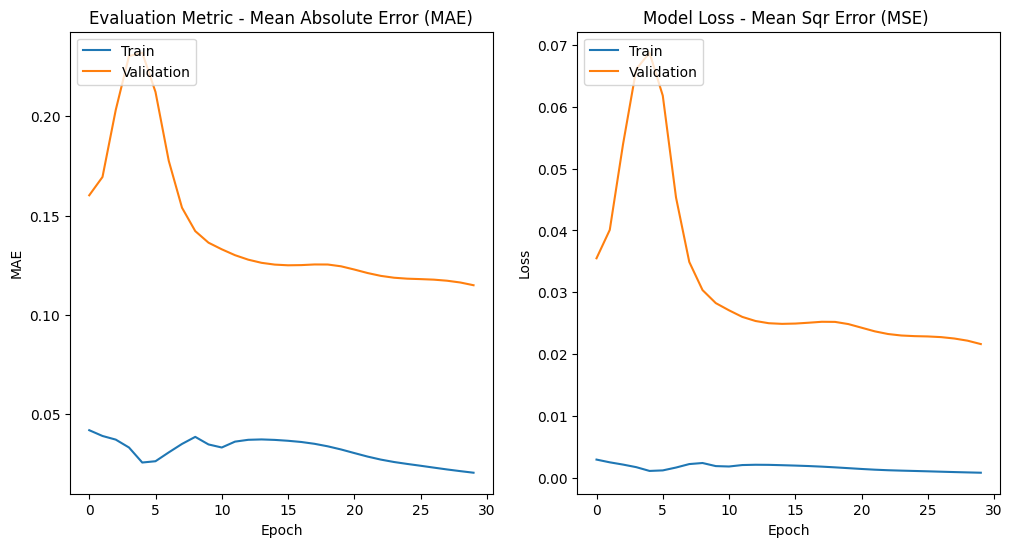

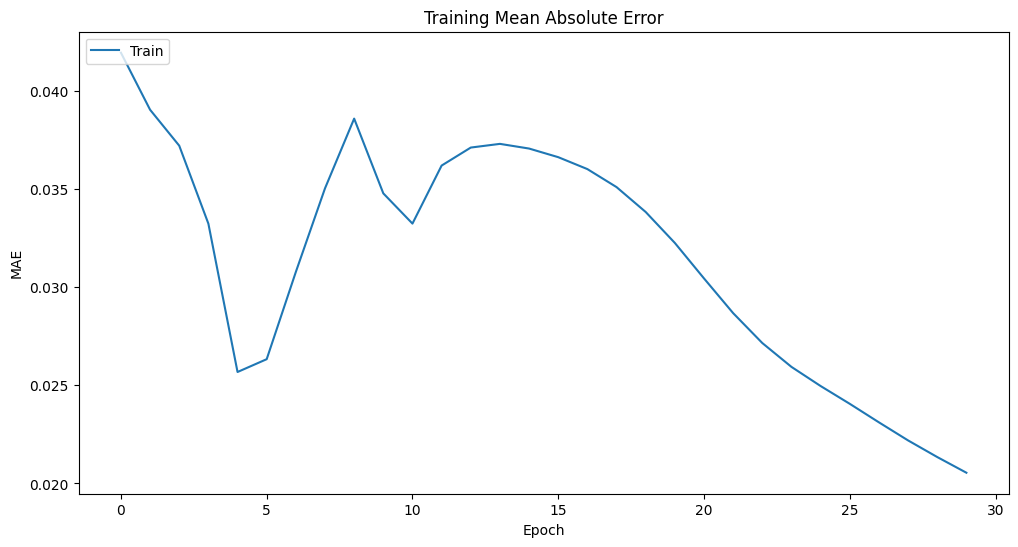

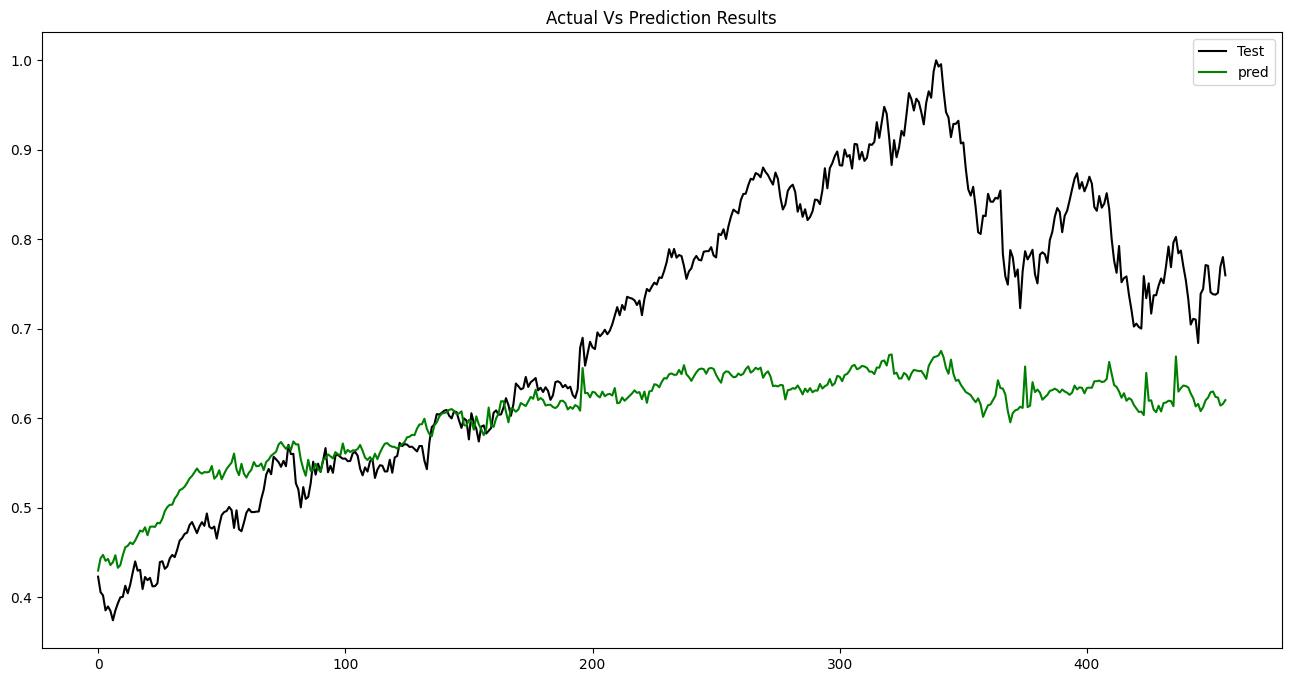

############################################################################
  Model Setup:
                    Name: MSI_F10_L2
             LSTM_Layers: 2
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: MSI
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 10
  Result Data:
             mean_abs_err =0.1297337490011137
             mean_sqr_err =0.025752484513195697
        root_mean_sqr_err =0.16047580662889874
           pred_diff_mean =0.9004437973565593
      pred_diff_bias_mean =0.09955620264344064
    pred_correctness_mean =0.5185995623632386



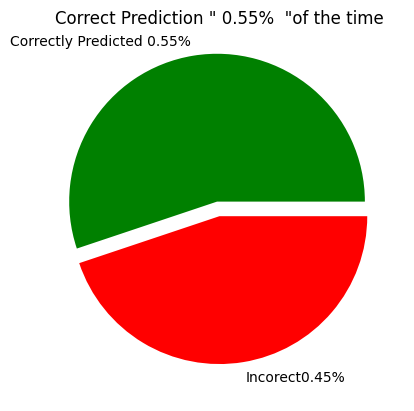

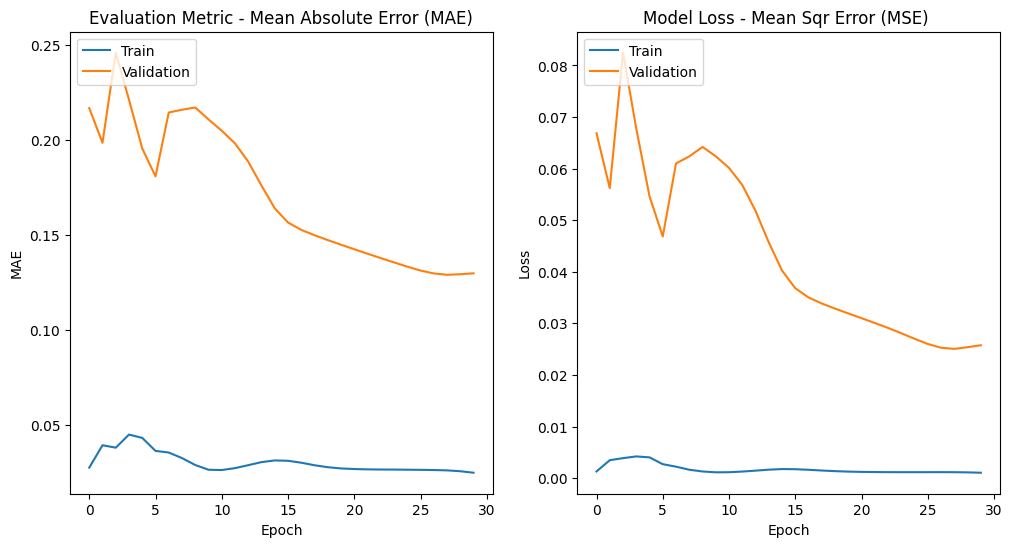

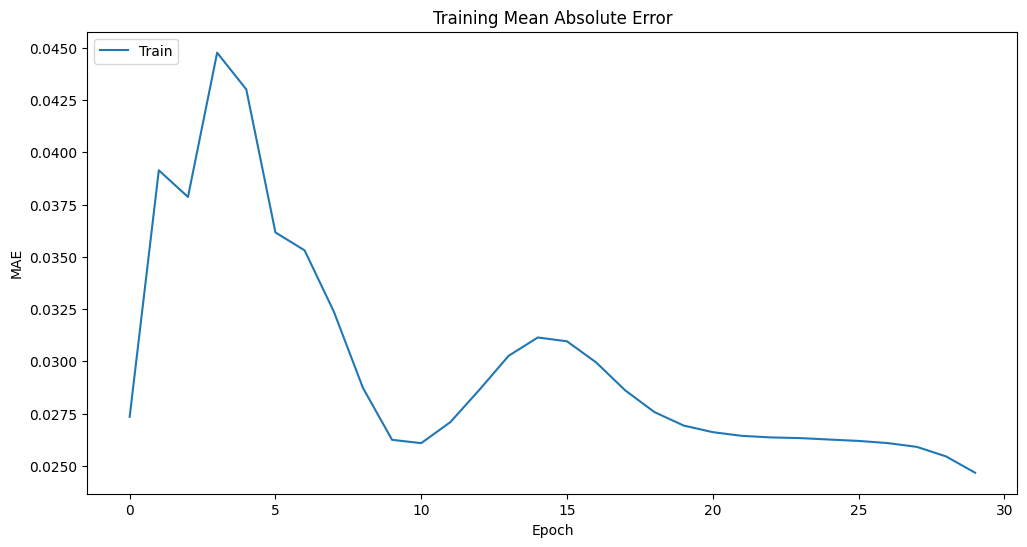

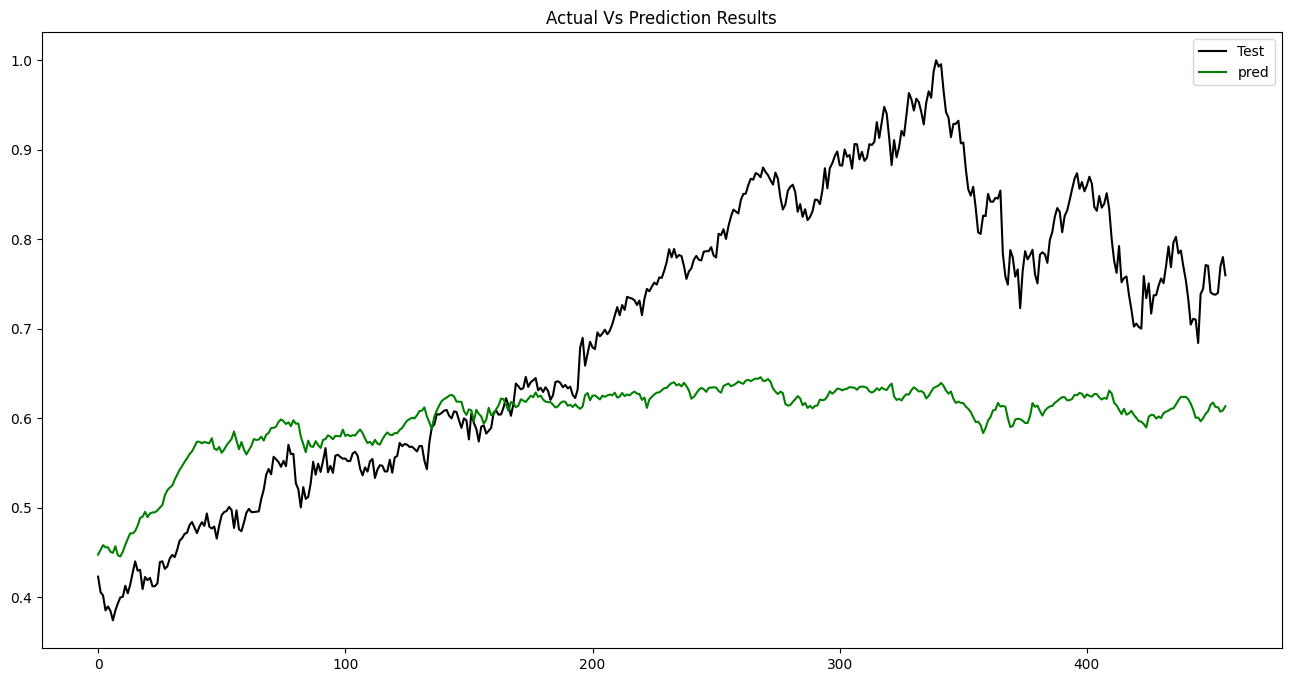

############################################################################
  Model Setup:
                    Name: MSI_F10_L3
             LSTM_Layers: 3
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: MSI
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 10
  Result Data:
             mean_abs_err =0.12341428255337923
             mean_sqr_err =0.02392804639122005
        root_mean_sqr_err =0.1546869302533994
           pred_diff_mean =0.9022806583504454
      pred_diff_bias_mean =0.09771934164955456
    pred_correctness_mean =0.5207877461706784



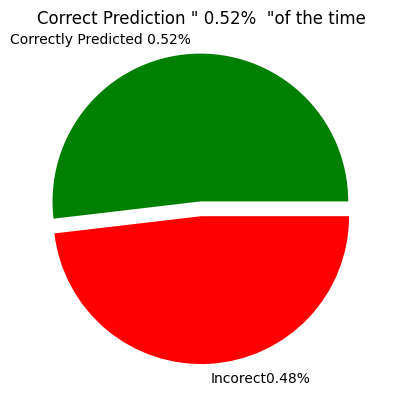

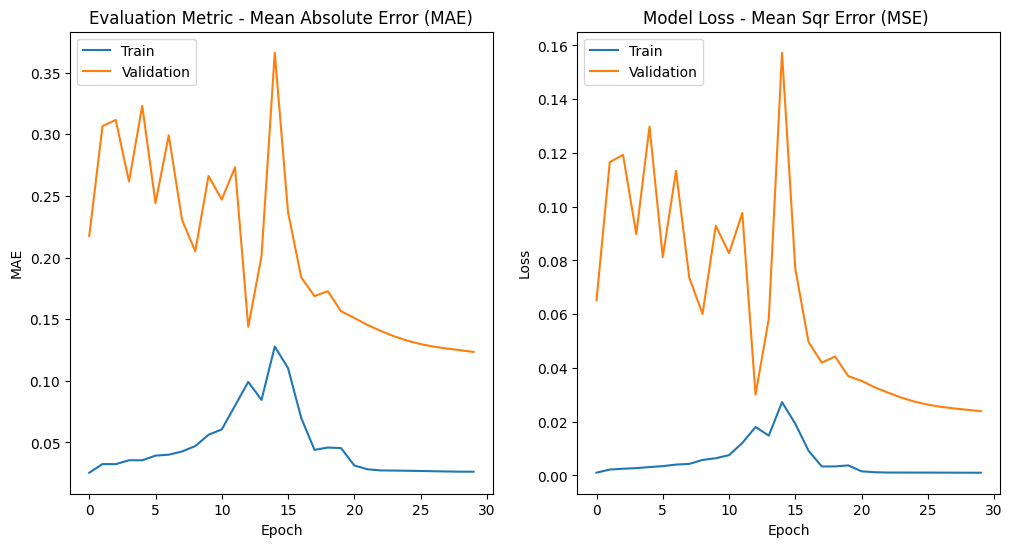

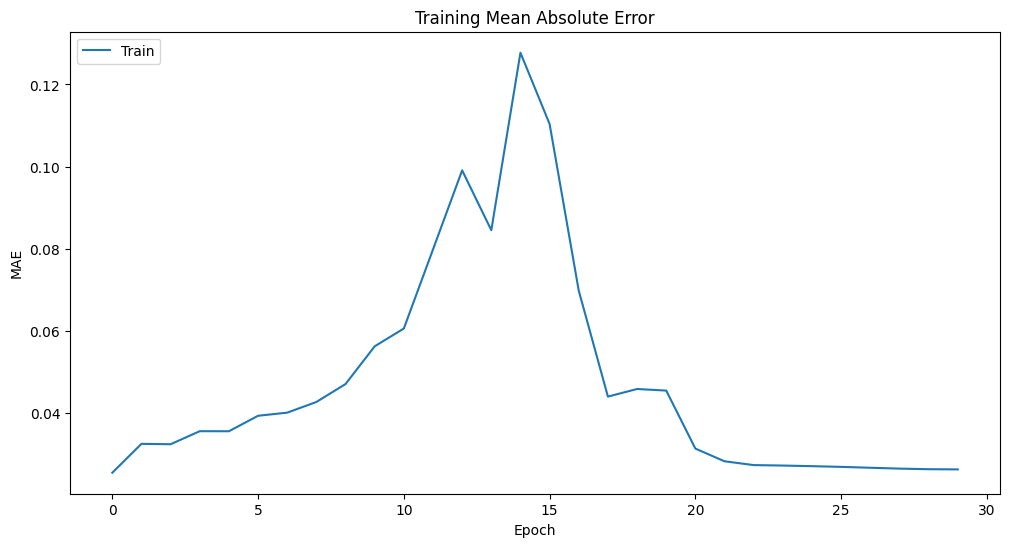

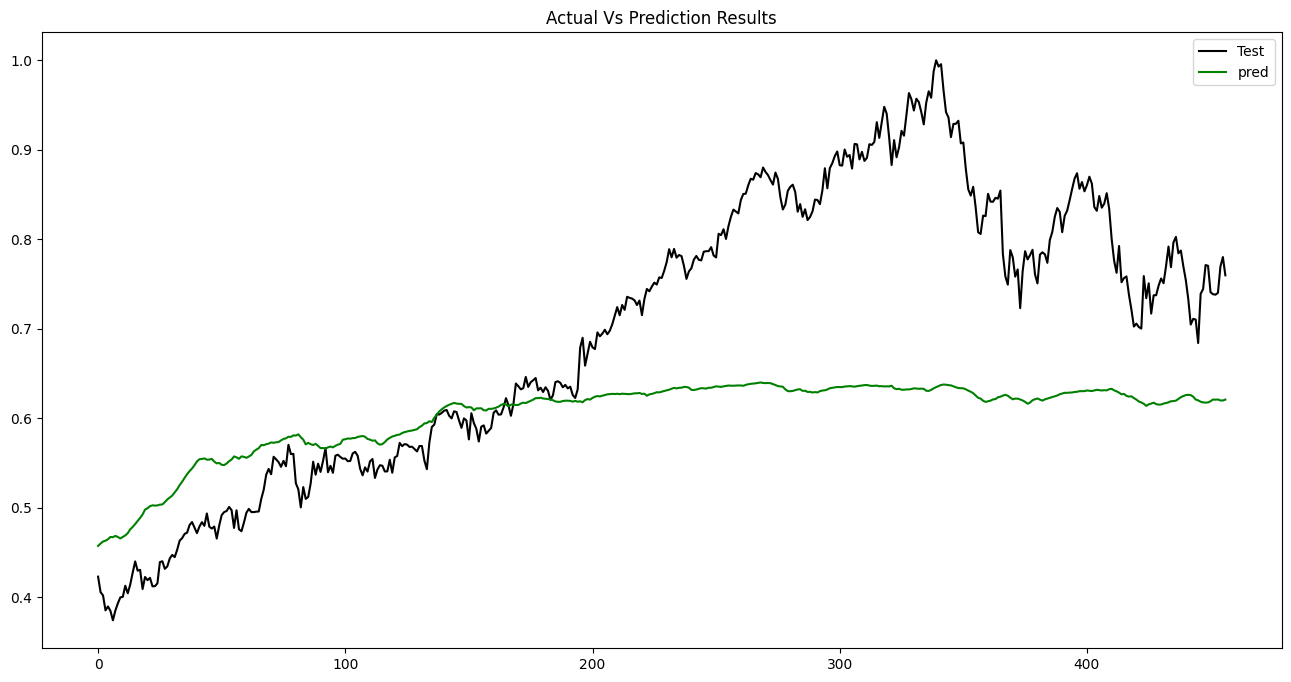

############################################################################
  Model Setup:
                    Name: MSI_F10_L4
             LSTM_Layers: 4
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: MSI
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 10
  Result Data:
             mean_abs_err =0.1726191699574671
             mean_sqr_err =0.04464544237447858
        root_mean_sqr_err =0.21129468136817495
           pred_diff_mean =0.8263713037618259
      pred_diff_bias_mean =0.1736286962381742
    pred_correctness_mean =0.4485776805251641



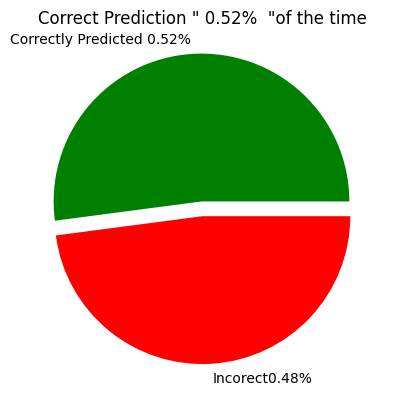

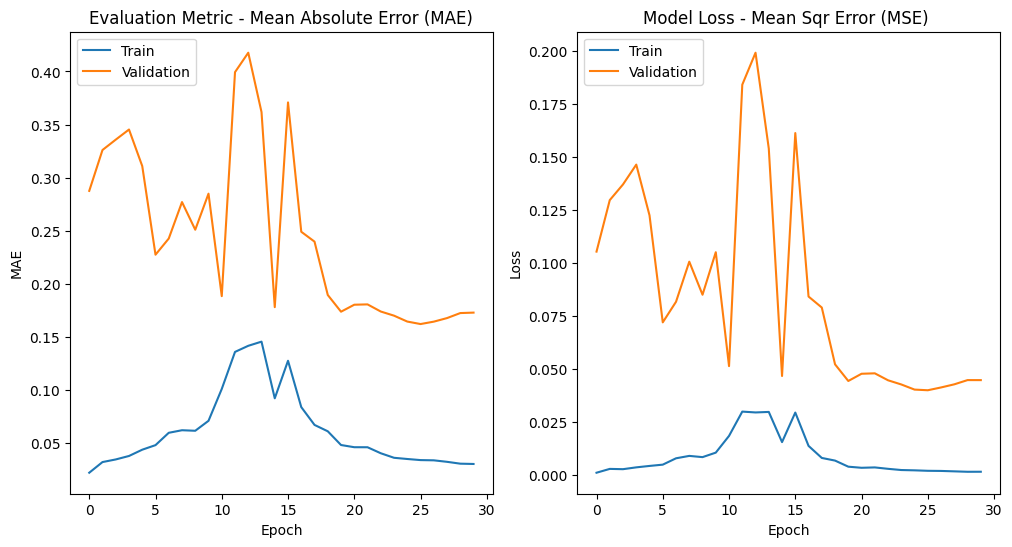

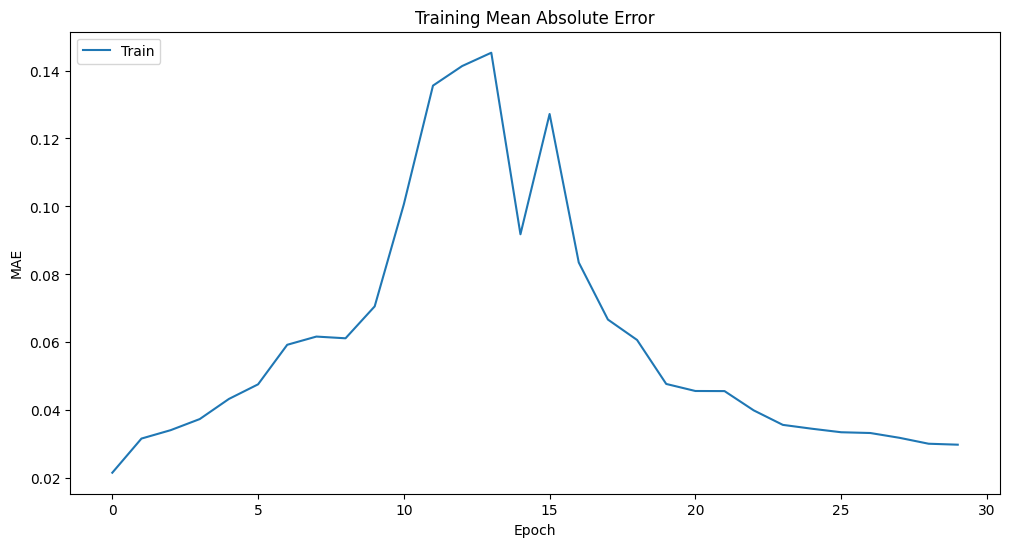

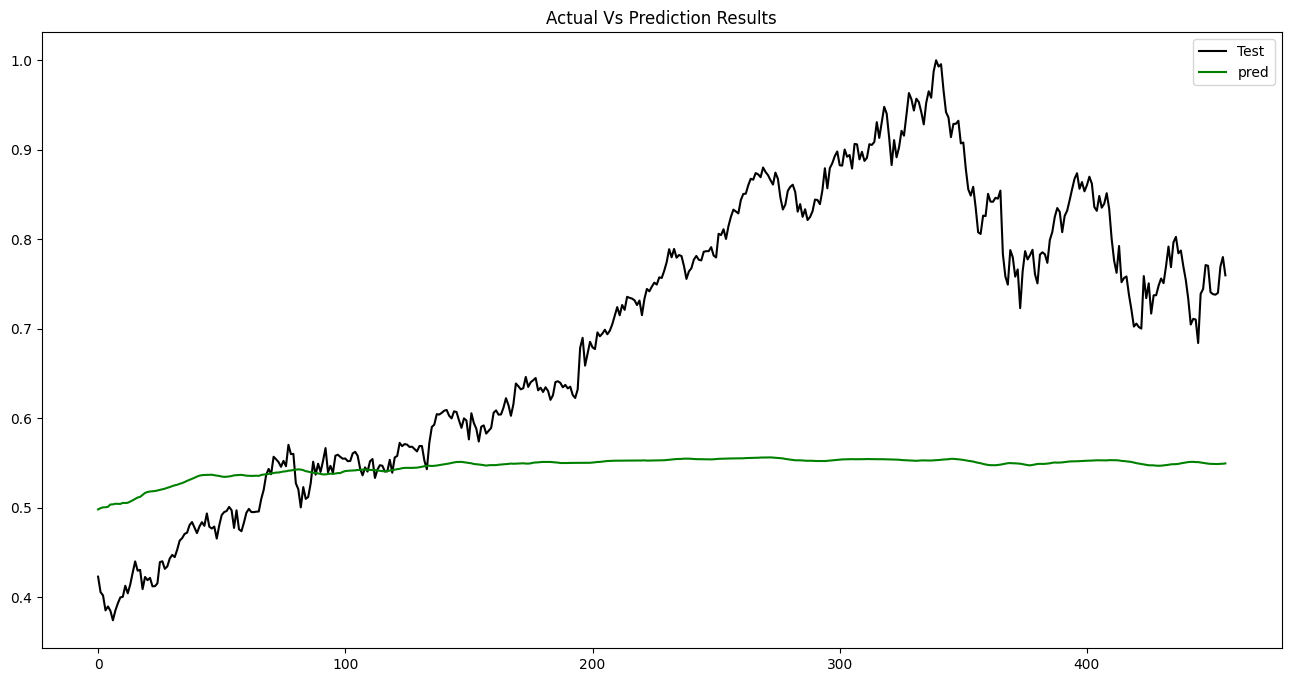

############################################################################
  Model Setup:
                    Name: MSI_F10_L5
             LSTM_Layers: 5
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: MSI
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 10
  Result Data:
             mean_abs_err =0.14994769057959542
             mean_sqr_err =0.034727851392568405
        root_mean_sqr_err =0.18635410216190146
           pred_diff_mean =0.8624220055782631
      pred_diff_bias_mean =0.13757799442173696
    pred_correctness_mean =0.4814004376367615



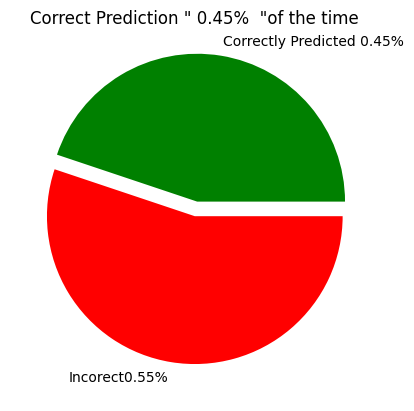

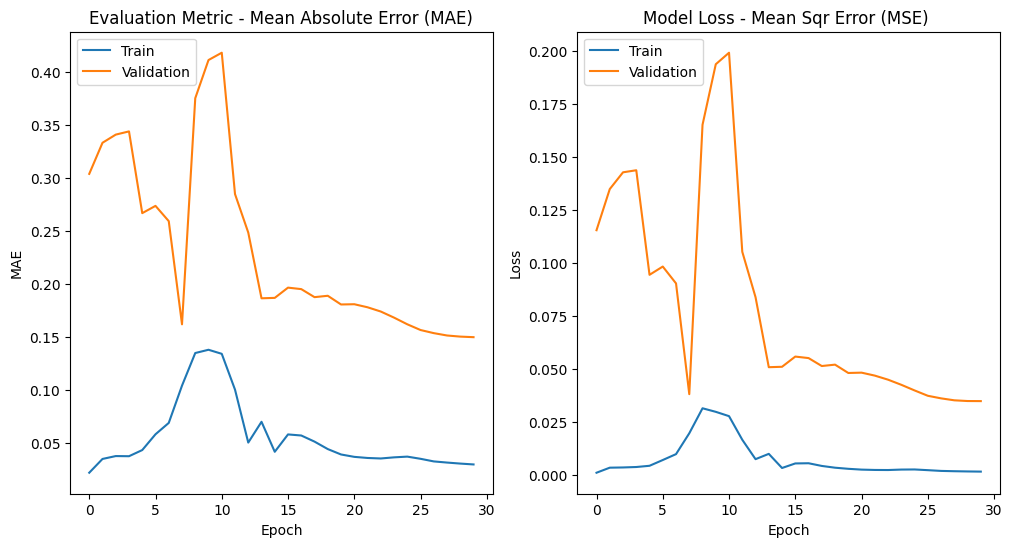

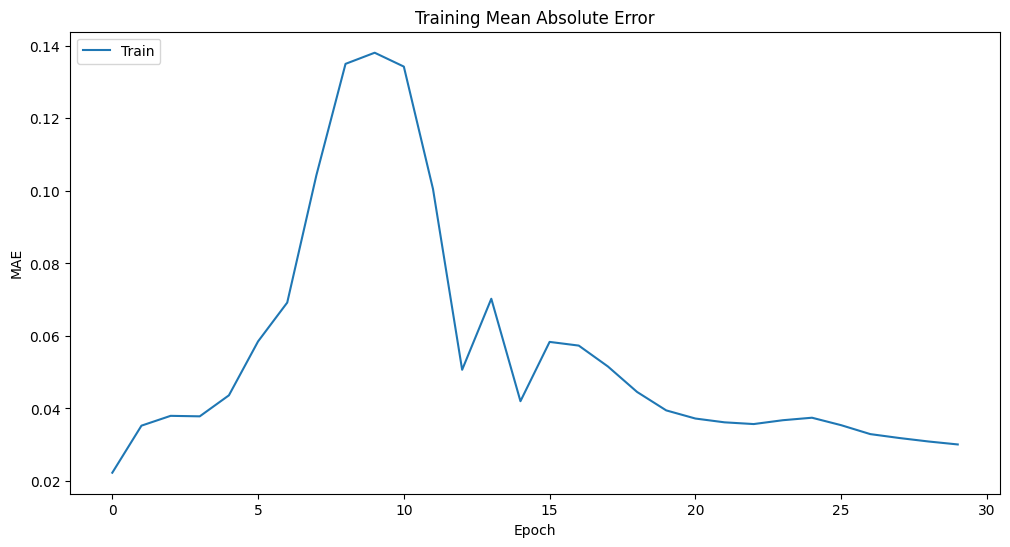

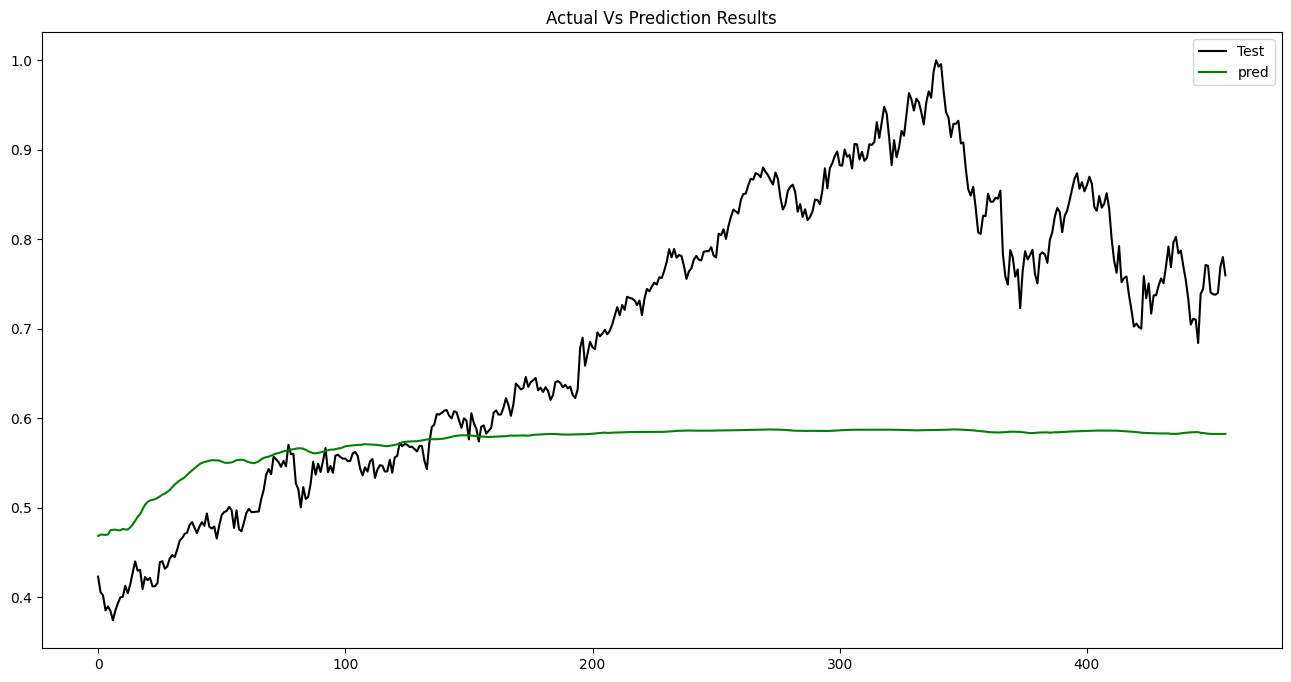

############################################################################
  Model Setup:
                    Name: MSI_F25_L1
             LSTM_Layers: 1
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: MSI
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 25
  Result Data:
             mean_abs_err =0.09300156161592867
             mean_sqr_err =0.01420734390083692
        root_mean_sqr_err =0.11919456321844936
           pred_diff_mean =0.9198347715832123
      pred_diff_bias_mean =0.08016522841678773
    pred_correctness_mean =0.6233480176211453



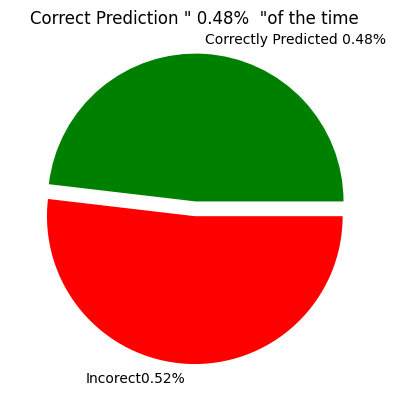

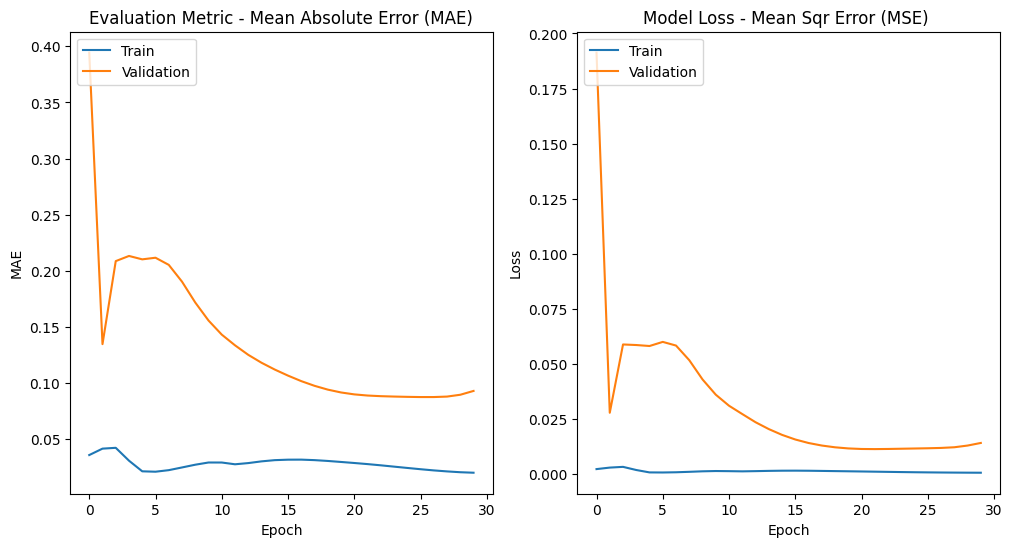

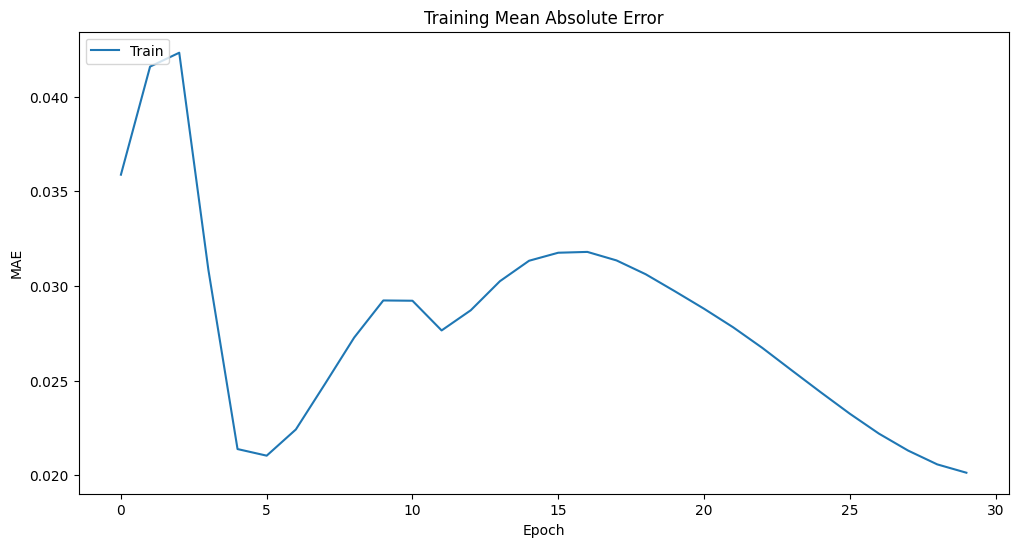

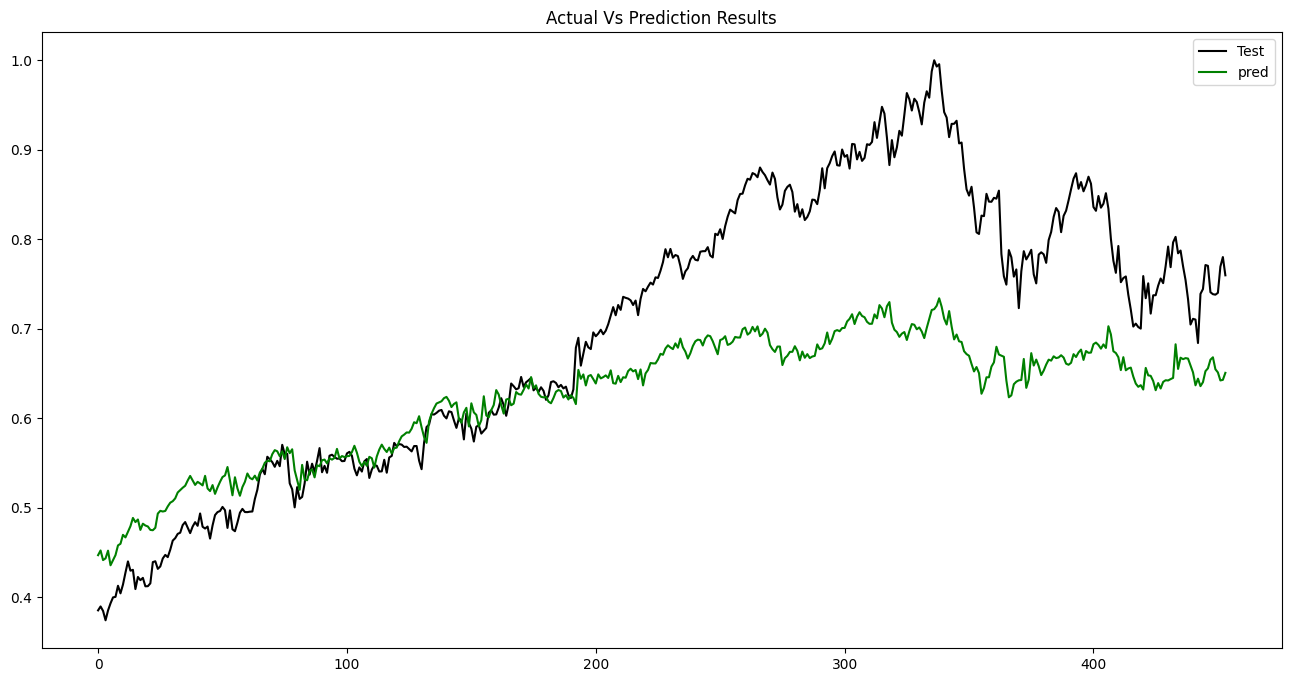

############################################################################
  Model Setup:
                    Name: MSI_F25_L2
             LSTM_Layers: 2
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: MSI
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 25
  Result Data:
             mean_abs_err =0.1312217999197649
             mean_sqr_err =0.026135547822415284
        root_mean_sqr_err =0.1616649245272928
           pred_diff_mean =0.9002673312610887
      pred_diff_bias_mean =0.09973266873891137
    pred_correctness_mean =0.5814977973568282



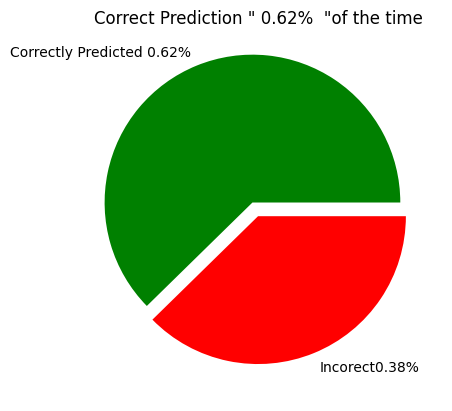

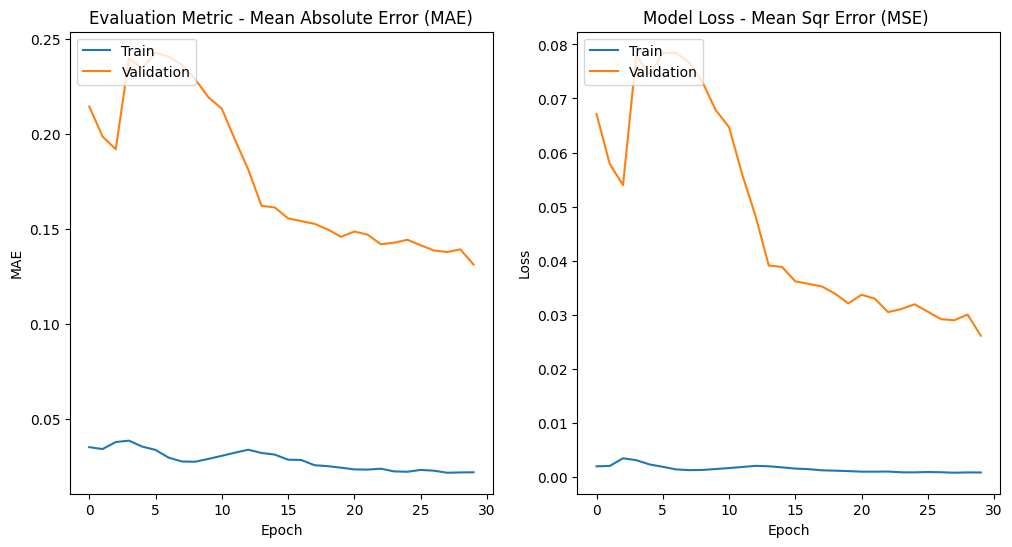

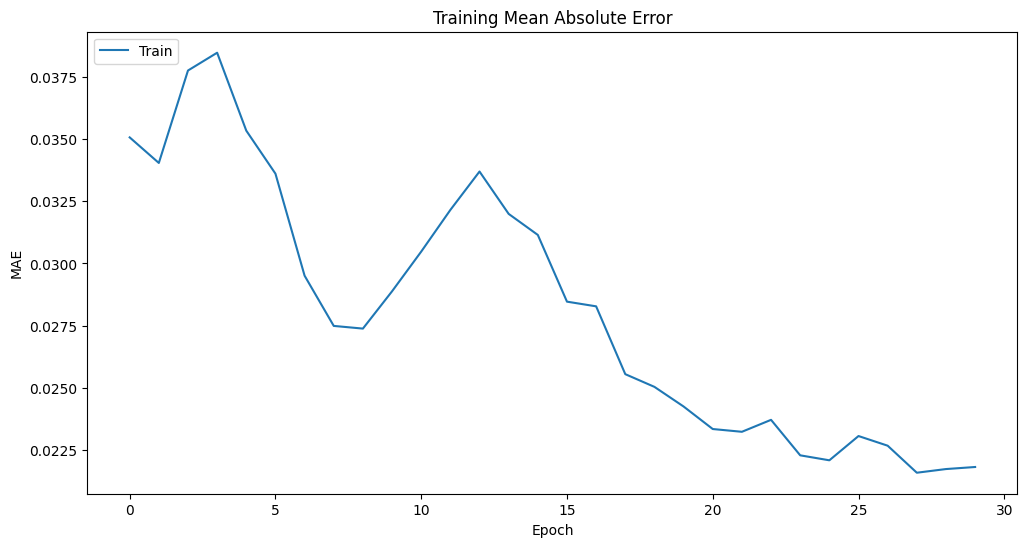

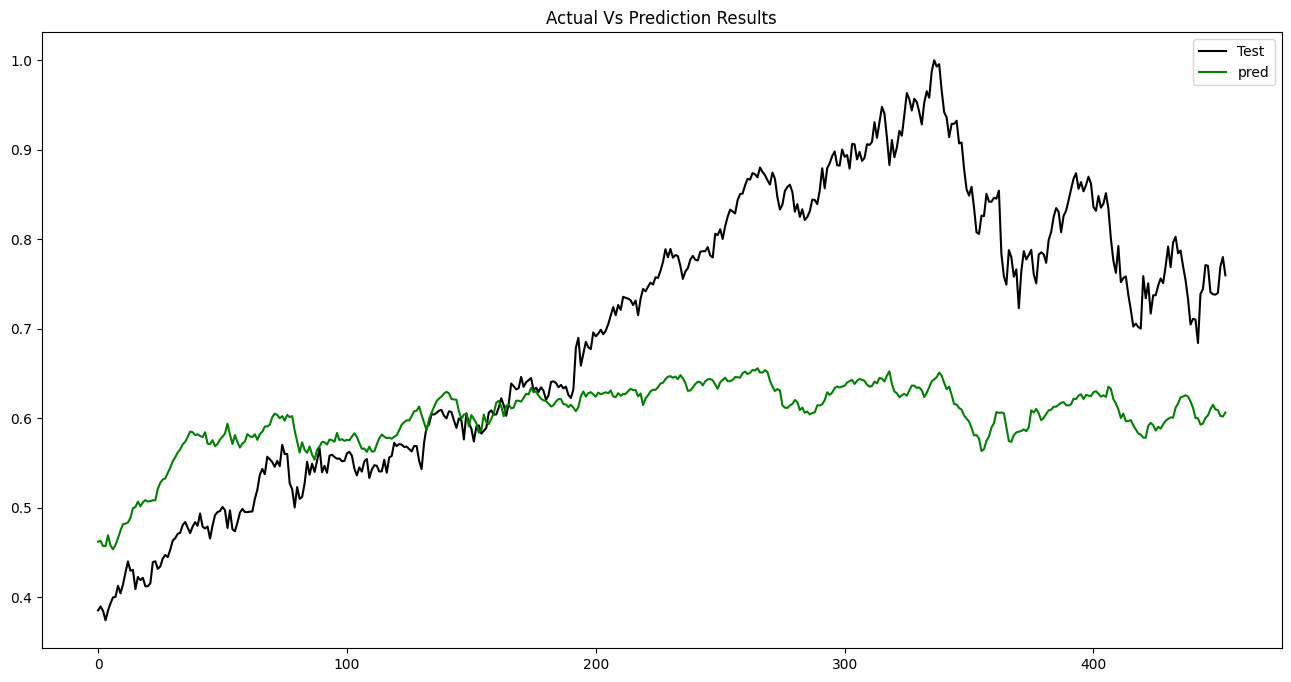

############################################################################
  Model Setup:
                    Name: MSI_F25_L3
             LSTM_Layers: 3
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: MSI
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 25
  Result Data:
             mean_abs_err =0.14384699215907537
             mean_sqr_err =0.03209990122640034
        root_mean_sqr_err =0.17916445302124065
           pred_diff_mean =0.8683412745038466
      pred_diff_bias_mean =0.13165872549615343
    pred_correctness_mean =0.5220264317180616



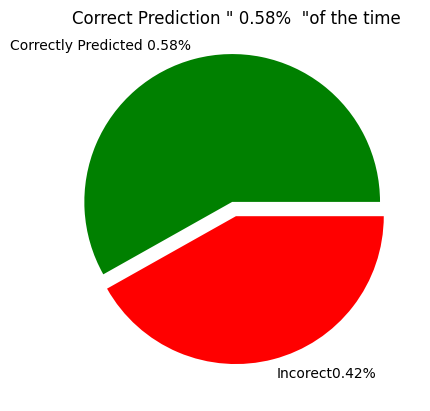

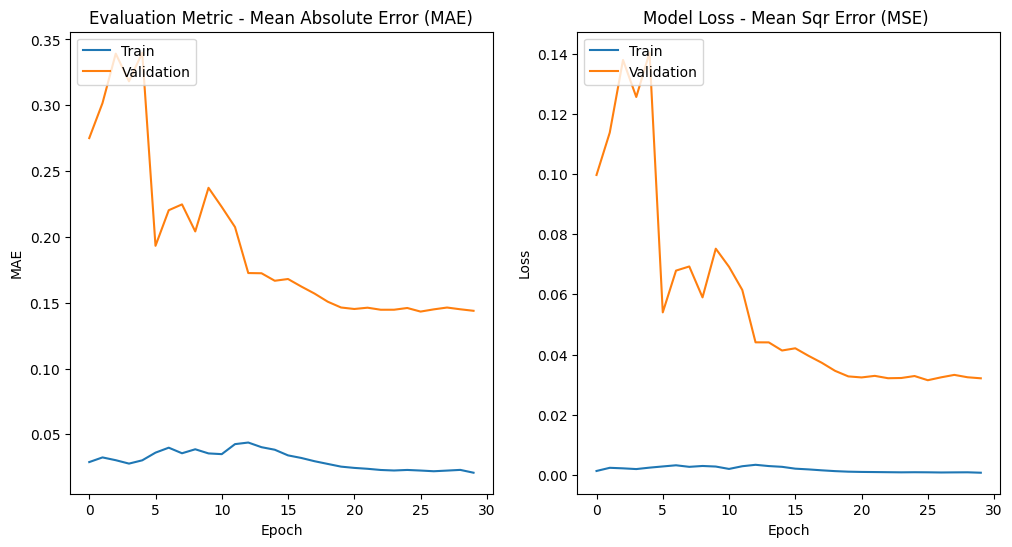

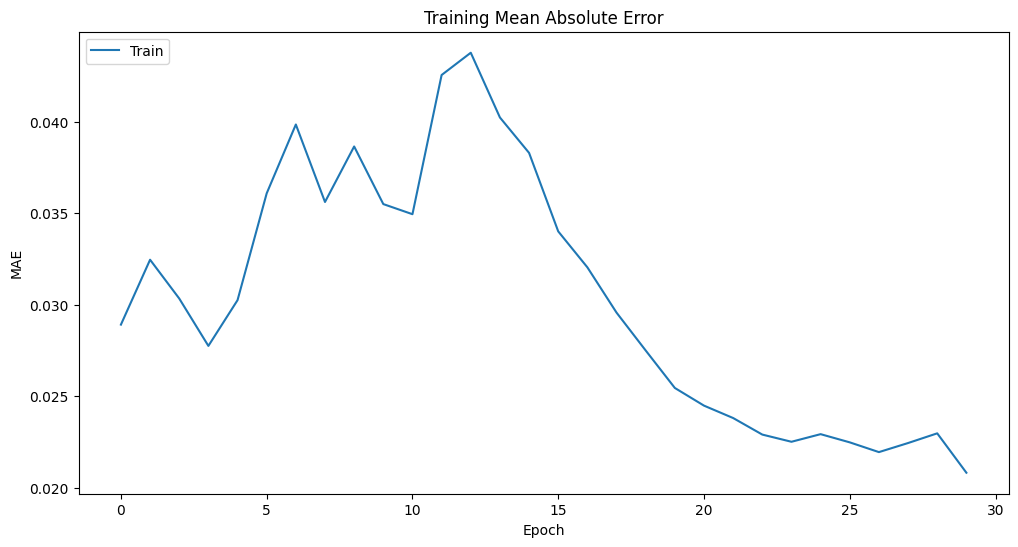

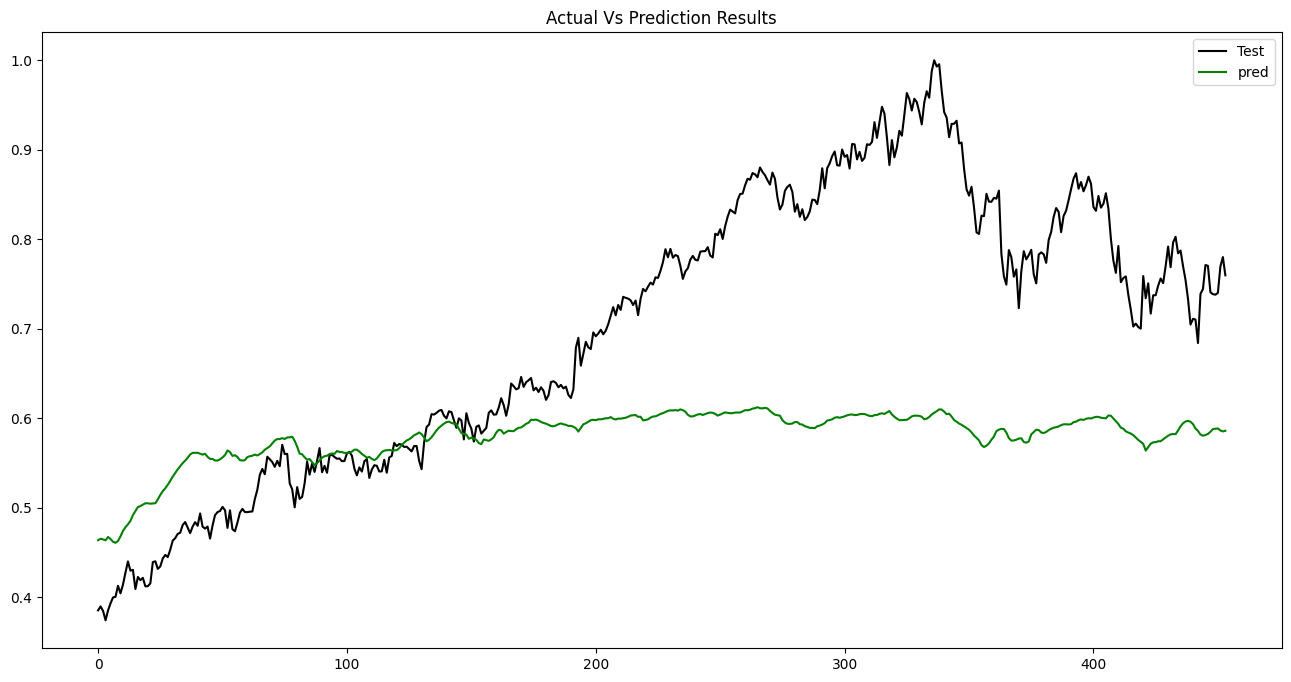

############################################################################
  Model Setup:
                    Name: MSI_F25_L4
             LSTM_Layers: 4
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: MSI
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 25
  Result Data:
             mean_abs_err =0.4635678435178696
             mean_sqr_err =0.23921833395445902
        root_mean_sqr_err =0.4890995133451464
           pred_diff_mean =0.3555713516024216
      pred_diff_bias_mean =0.6444286483975784
    pred_correctness_mean =0.2422907488986784



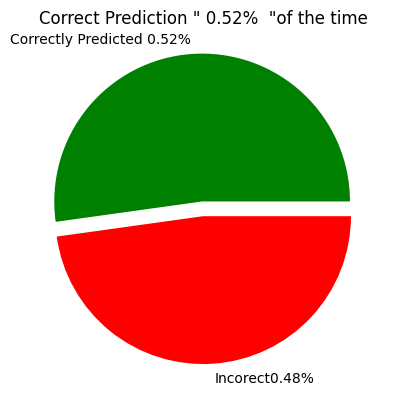

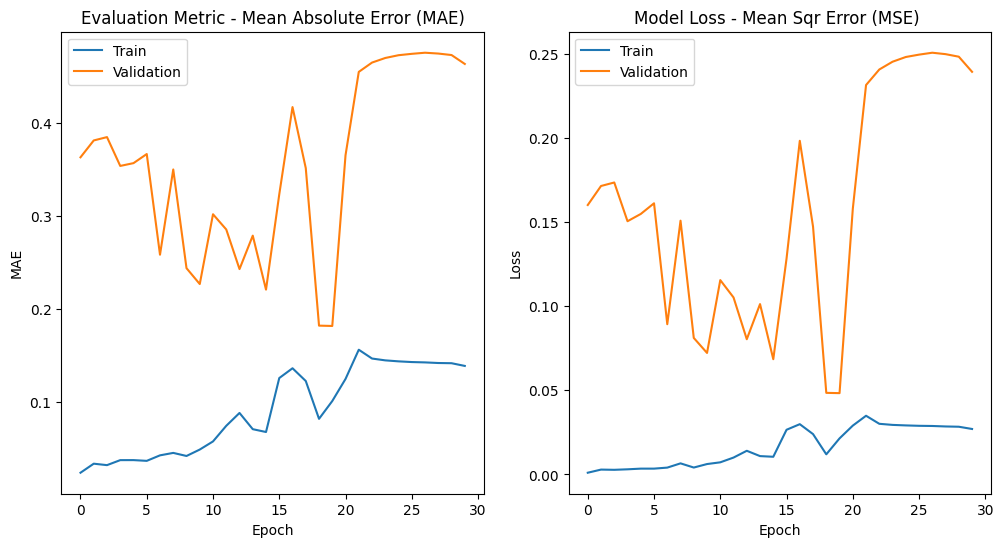

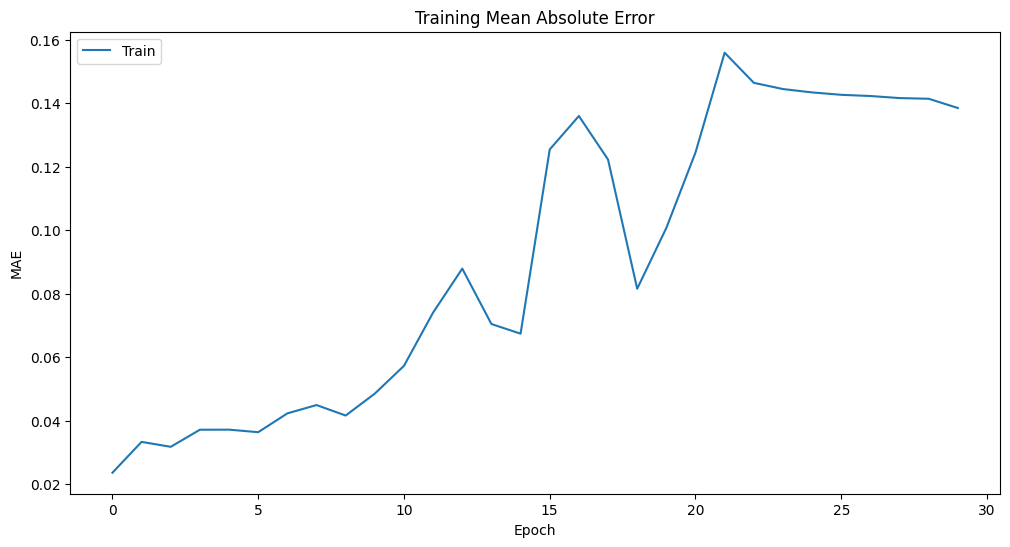

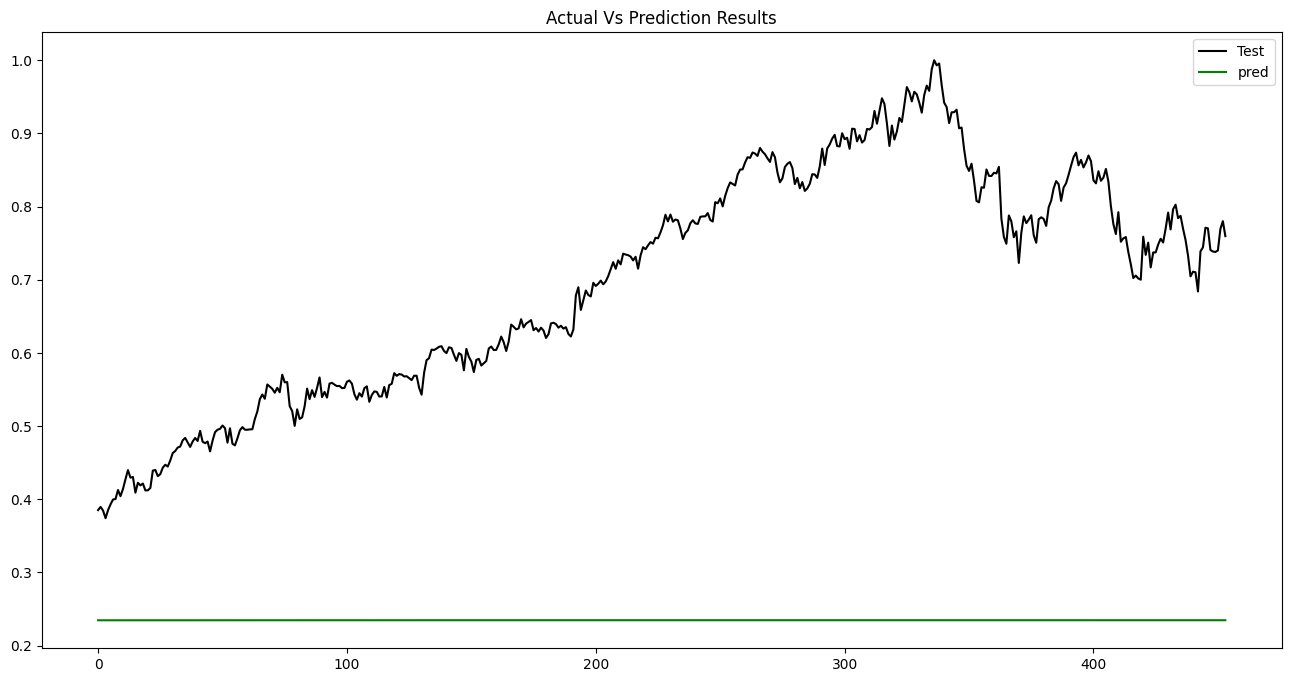

############################################################################
  Model Setup:
                    Name: MSI_F25_L5
             LSTM_Layers: 5
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: MSI
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 25
  Result Data:
             mean_abs_err =0.4779493322948118
             mean_sqr_err =0.2527648203196538
        root_mean_sqr_err =0.5027572180681783
           pred_diff_mean =0.33379258841682546
      pred_diff_bias_mean =0.6662074115831746
    pred_correctness_mean =0.2422907488986784



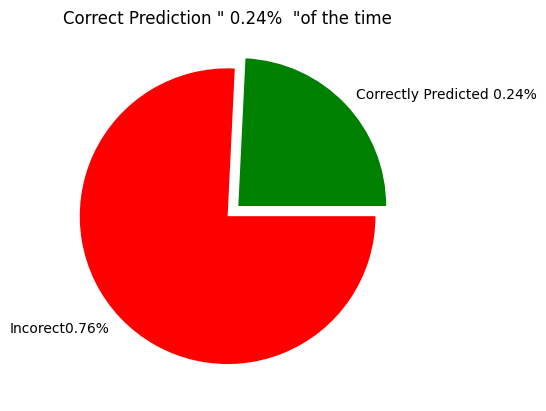

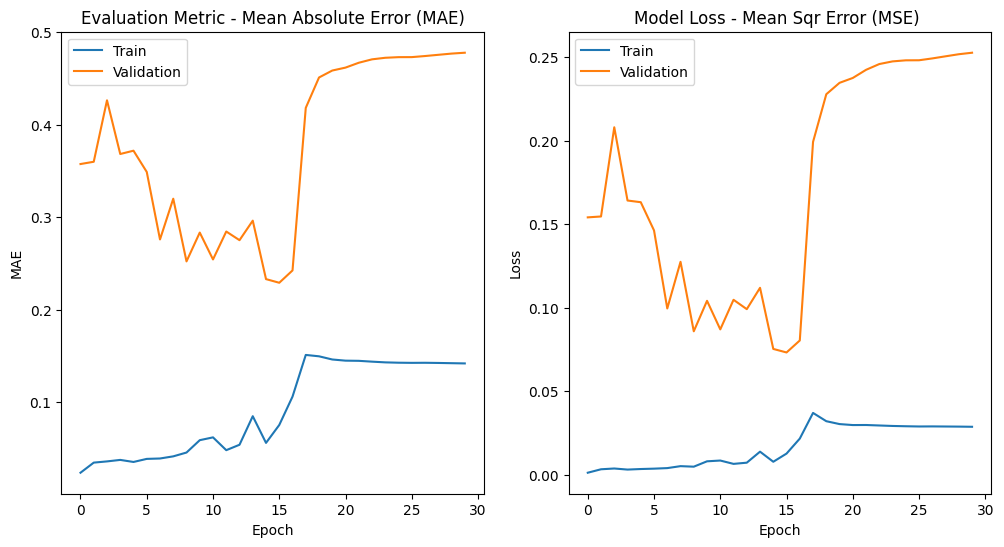

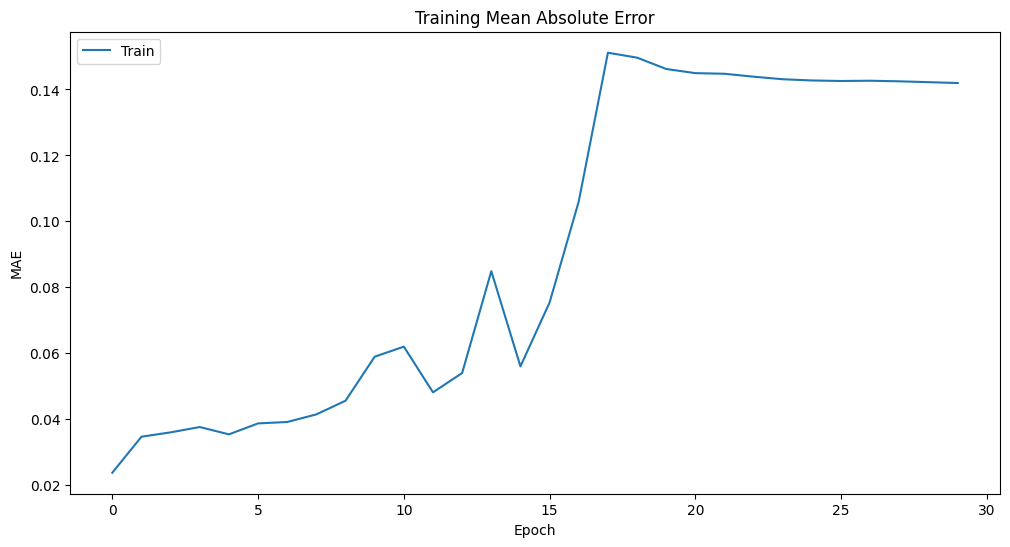

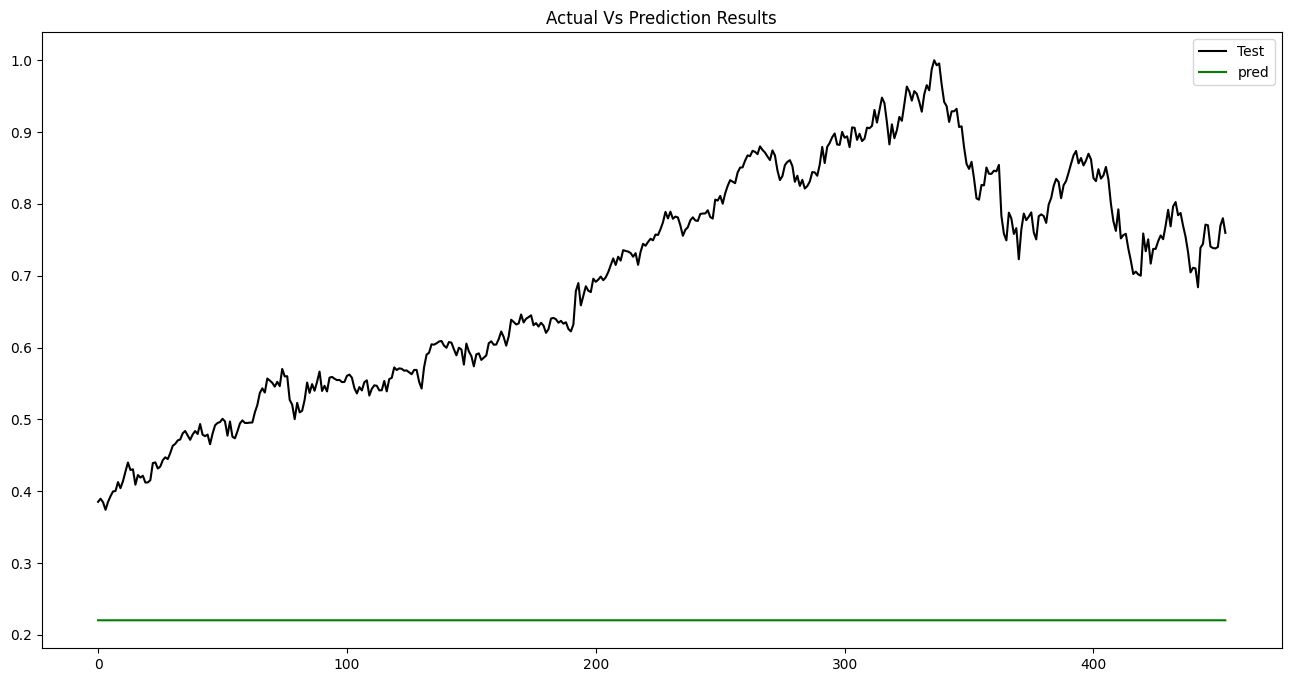

############################################################################
  Model Setup:
                    Name: MSI_F50_L1
             LSTM_Layers: 1
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: MSI
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 50
  Result Data:
             mean_abs_err =0.10346648955193768
             mean_sqr_err =0.017153518014900608
        root_mean_sqr_err =0.1309714396916389
           pred_diff_mean =0.9180947603104687
      pred_diff_bias_mean =0.08190523968953152
    pred_correctness_mean =0.7394209354120267



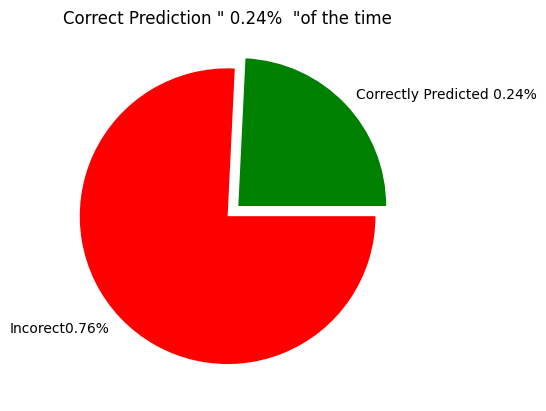

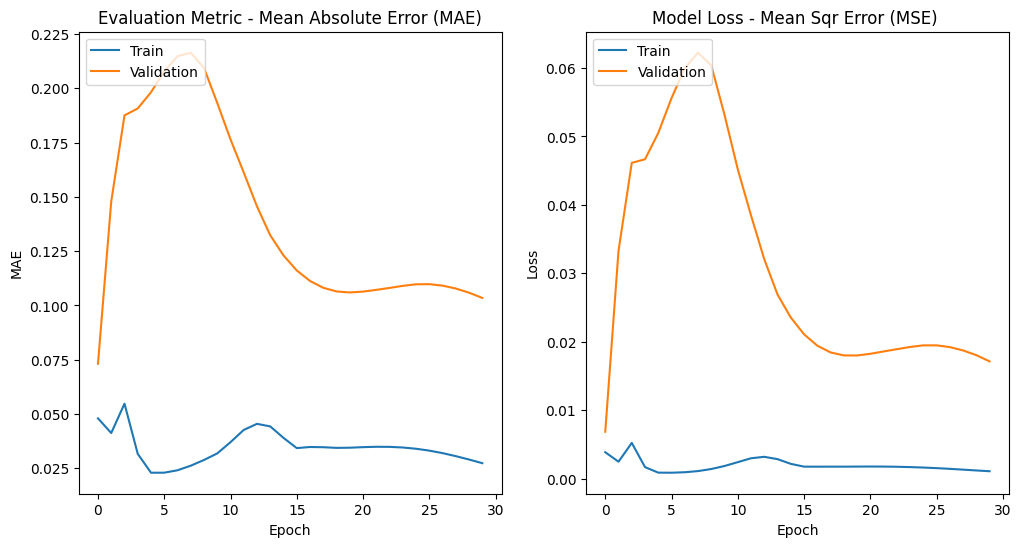

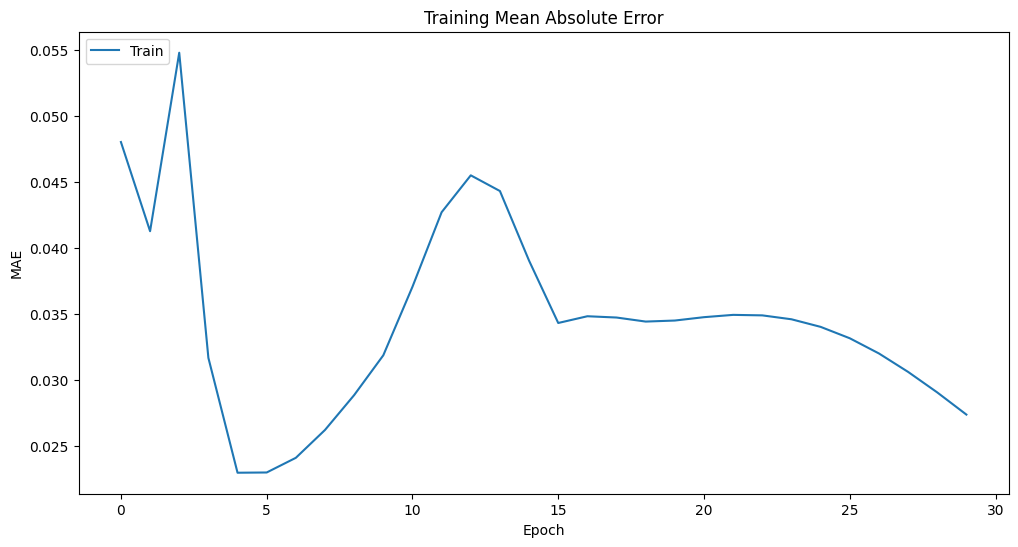

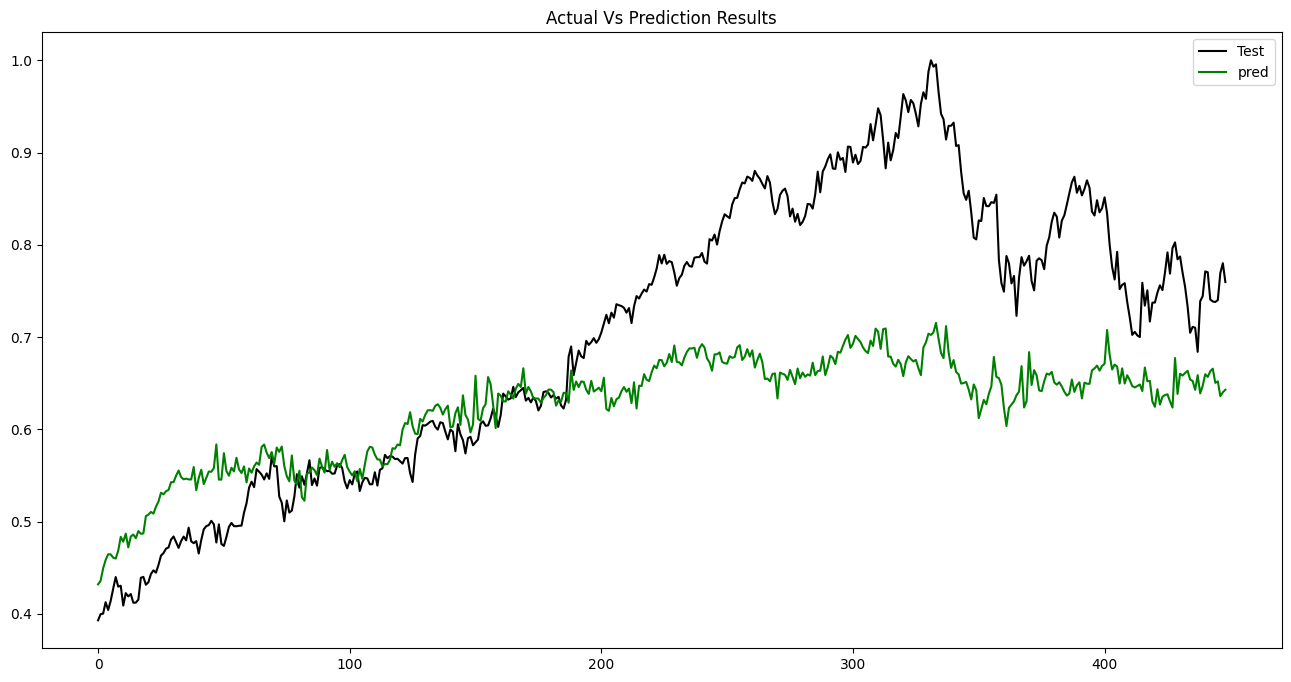

############################################################################
  Model Setup:
                    Name: MSI_F50_L2
             LSTM_Layers: 2
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: MSI
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 50
  Result Data:
             mean_abs_err =0.1361701642965664
             mean_sqr_err =0.02973652239192376
        root_mean_sqr_err =0.17244280904672063
           pred_diff_mean =0.8658129850569143
      pred_diff_bias_mean =0.13418701494308588
    pred_correctness_mean =0.6614699331848553



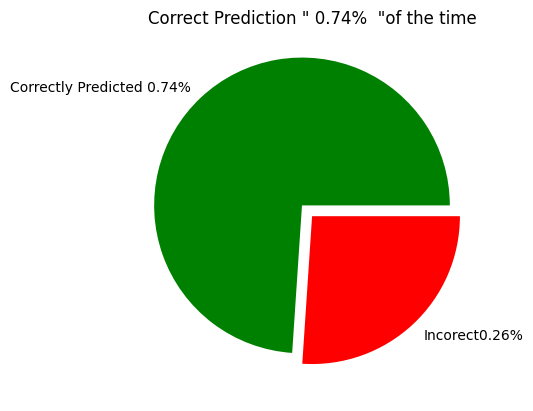

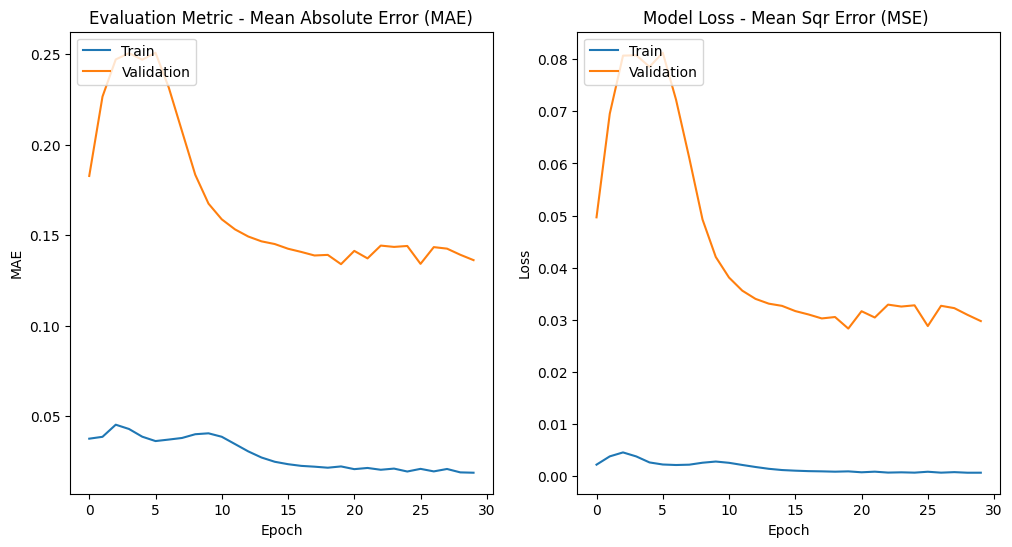

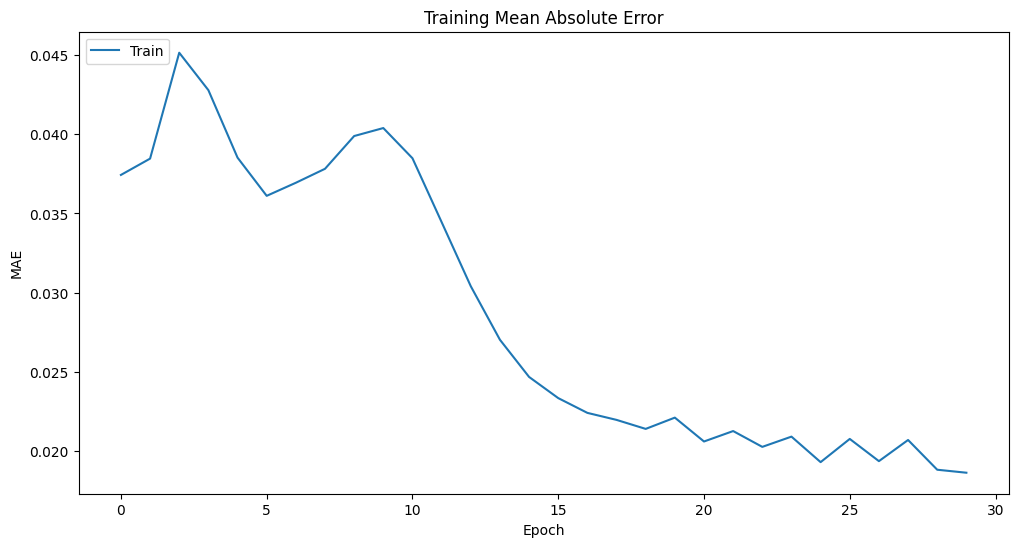

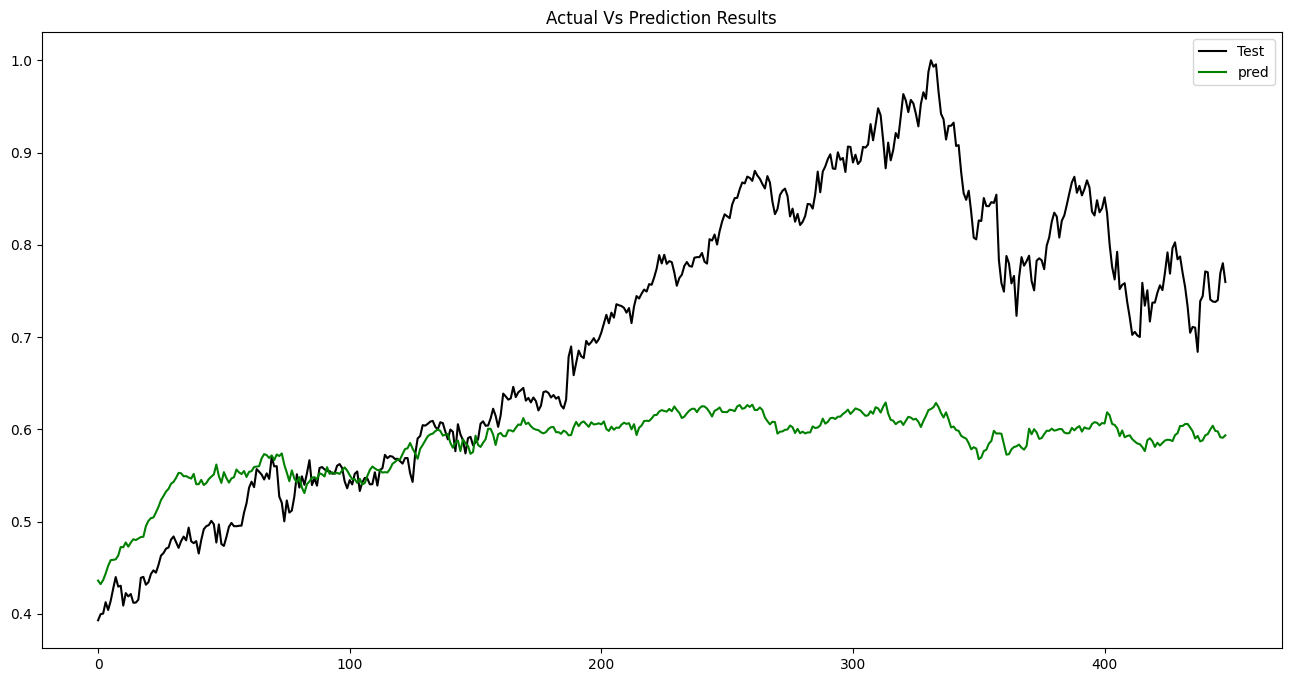

############################################################################
  Model Setup:
                    Name: MSI_F50_L3
             LSTM_Layers: 3
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: MSI
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 50
  Result Data:
             mean_abs_err =0.25796907010054987
             mean_sqr_err =0.08607188362578475
        root_mean_sqr_err =0.29338010093696665
           pred_diff_mean =0.6643991407015591
      pred_diff_bias_mean =0.33560085929844097
    pred_correctness_mean =0.36080178173719374



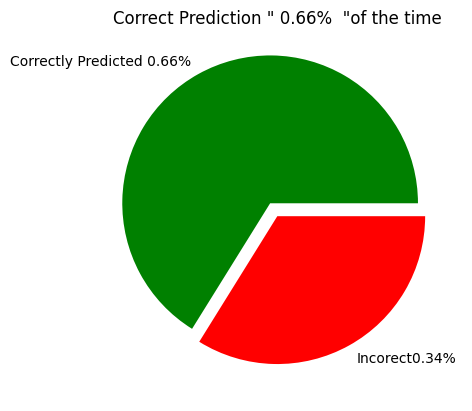

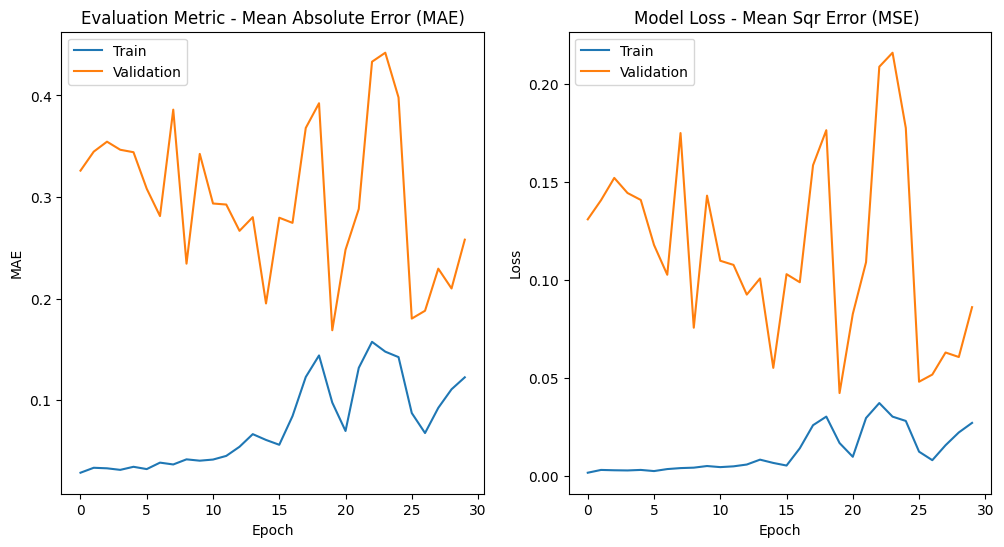

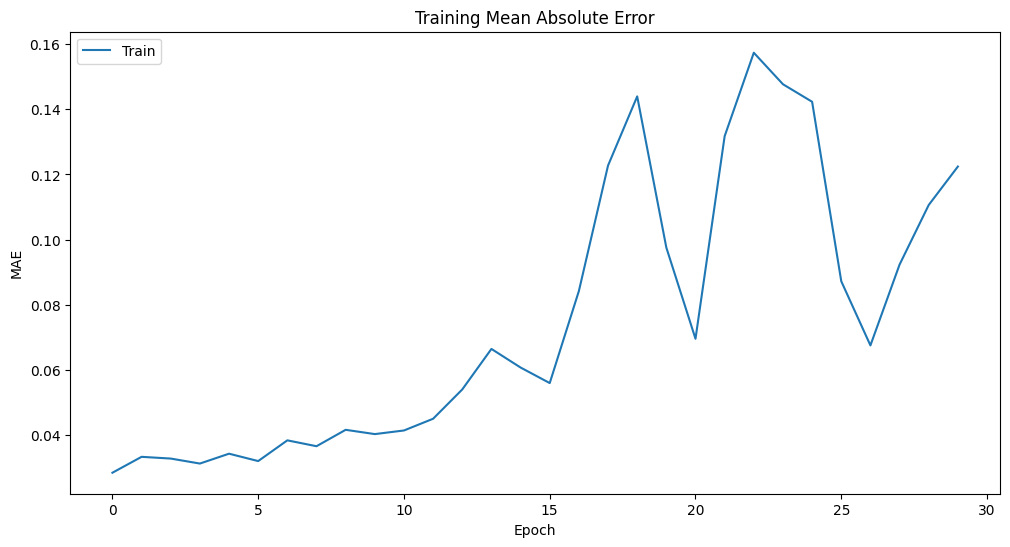

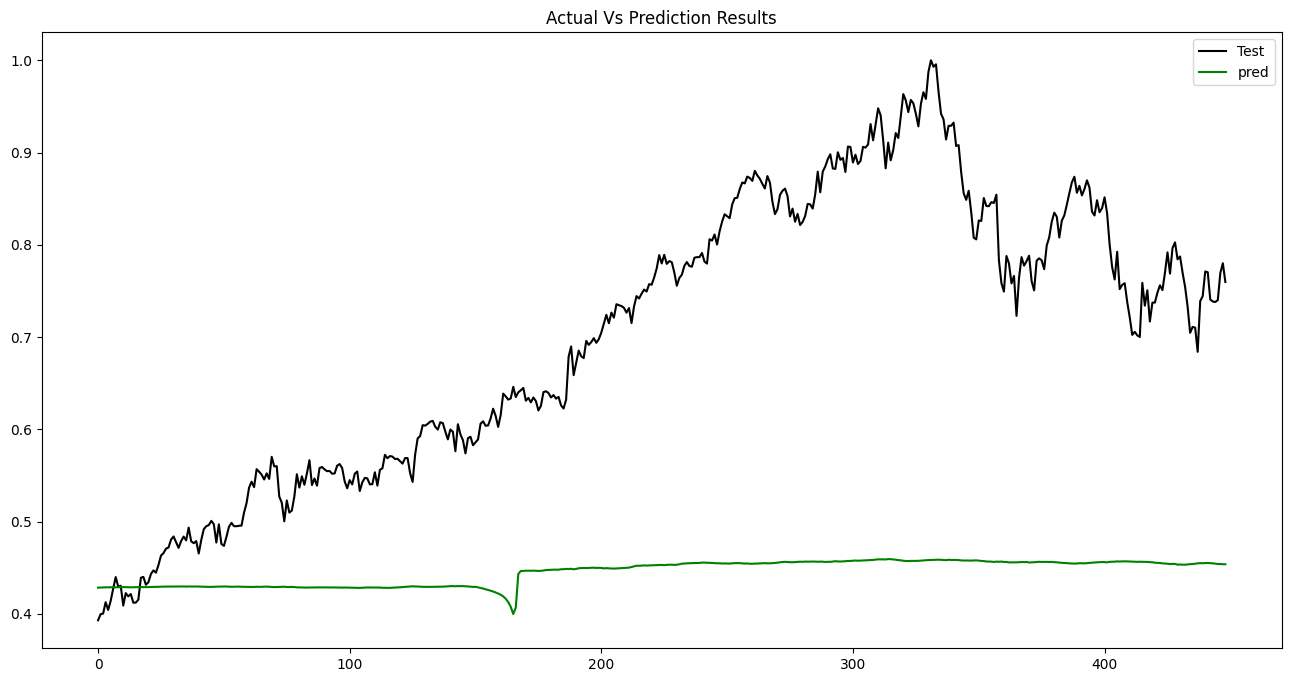

############################################################################
  Model Setup:
                    Name: MSI_F50_L4
             LSTM_Layers: 4
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: MSI
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 50
  Result Data:
             mean_abs_err =0.47440932826868654
             mean_sqr_err =0.24858253655638063
        root_mean_sqr_err =0.49858052163755917
           pred_diff_mean =0.34173328360479494
      pred_diff_bias_mean =0.6582667163952052
    pred_correctness_mean =0.22717149220489977



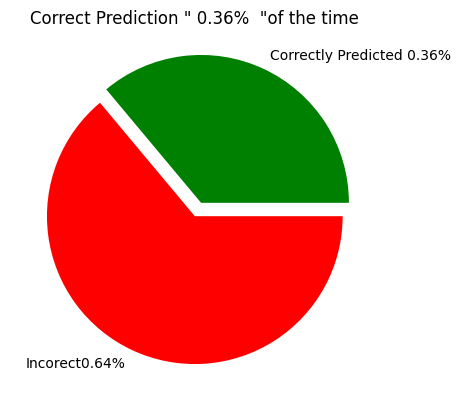

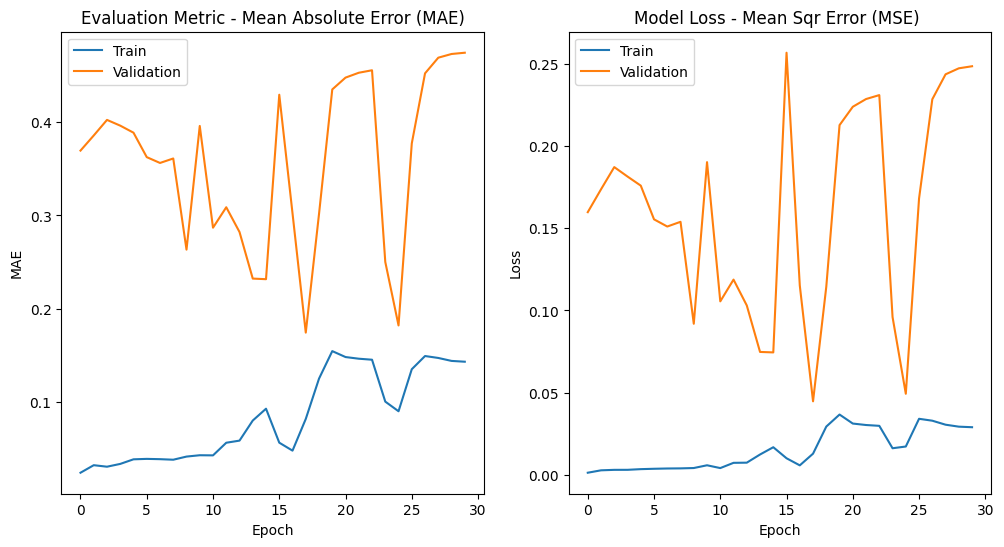

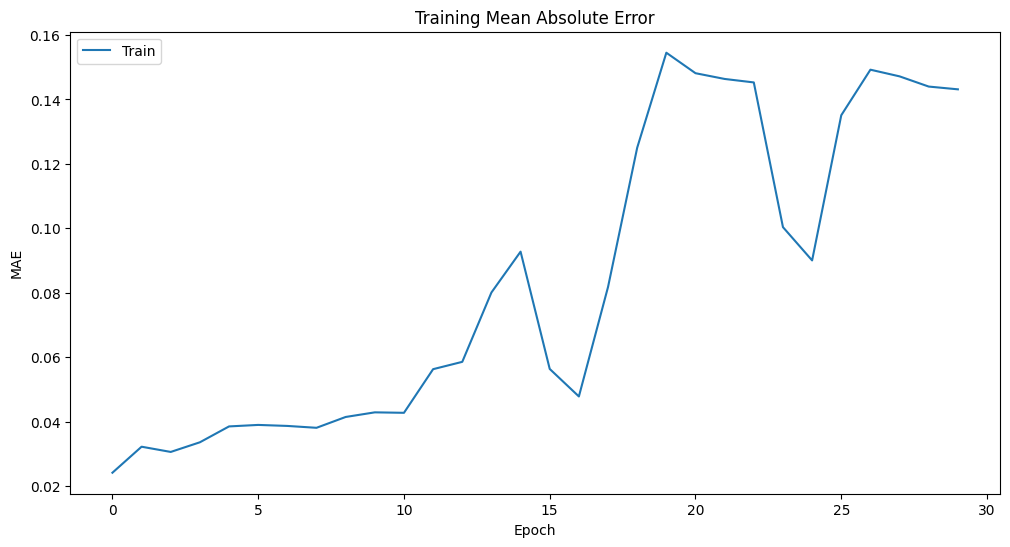

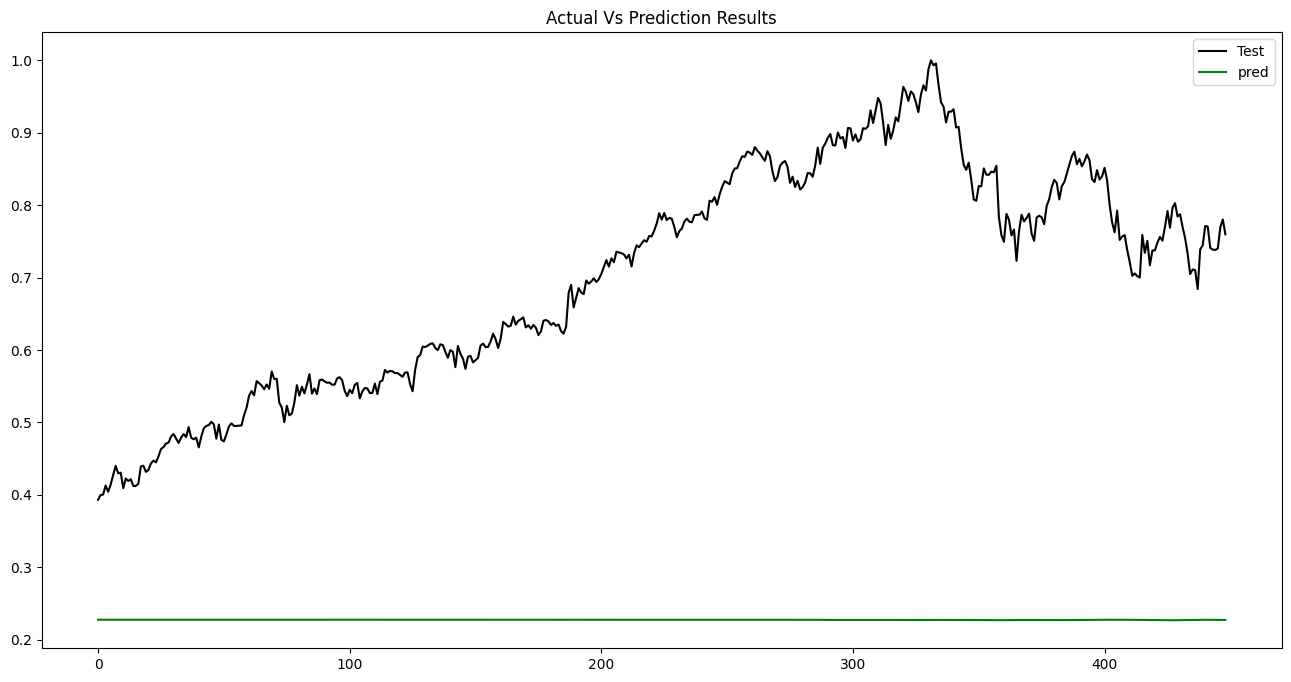

############################################################################
  Model Setup:
                    Name: MSI_F50_L5
             LSTM_Layers: 5
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: MSI
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 50
  Result Data:
             mean_abs_err =0.4748068970239532
             mean_sqr_err =0.24892779433481876
        root_mean_sqr_err =0.49892664223793337
           pred_diff_mean =0.3411009056189319
      pred_diff_bias_mean =0.6588990943810681
    pred_correctness_mean =0.22717149220489977



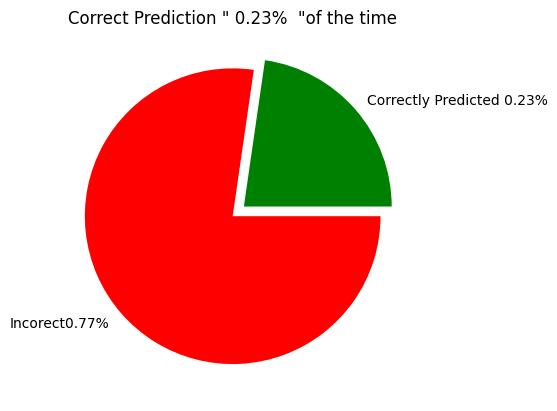

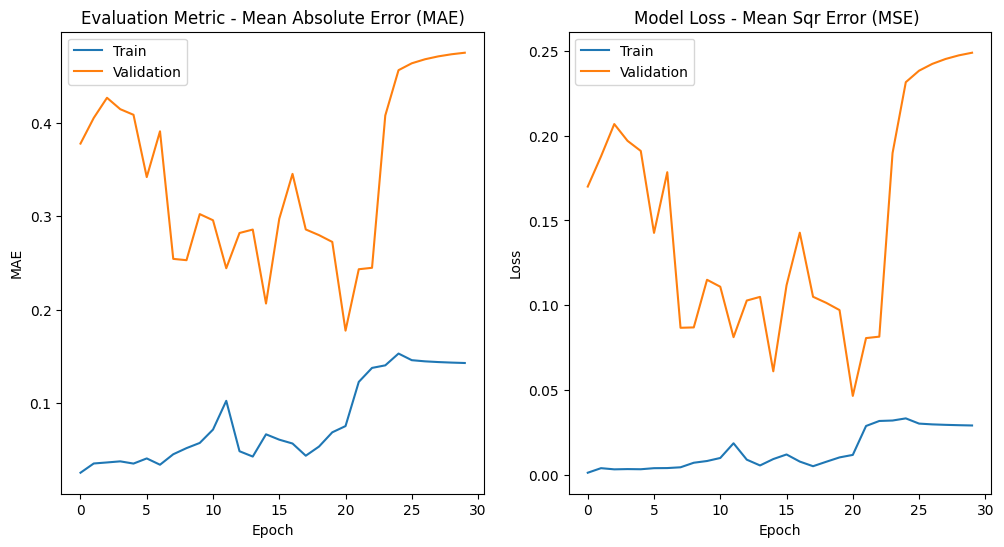

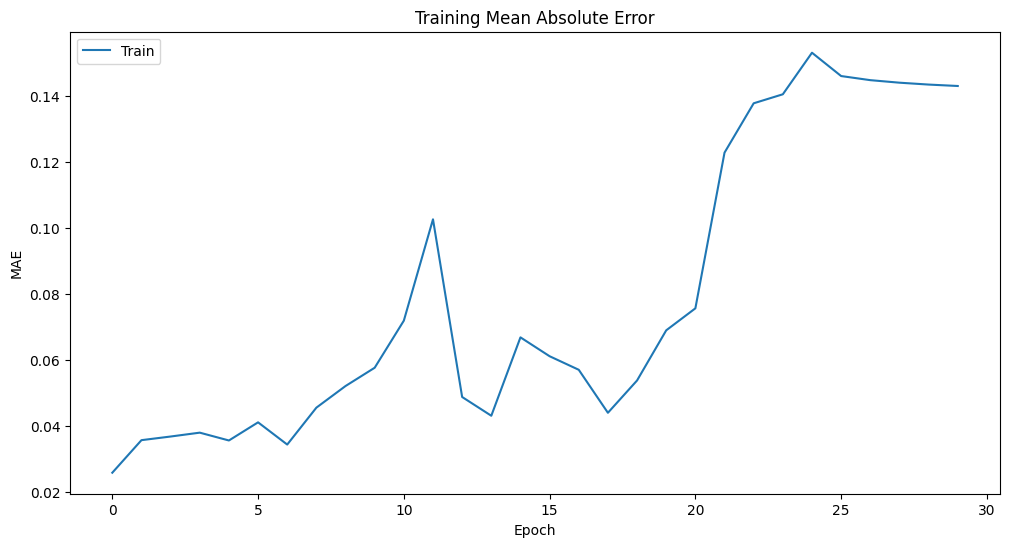

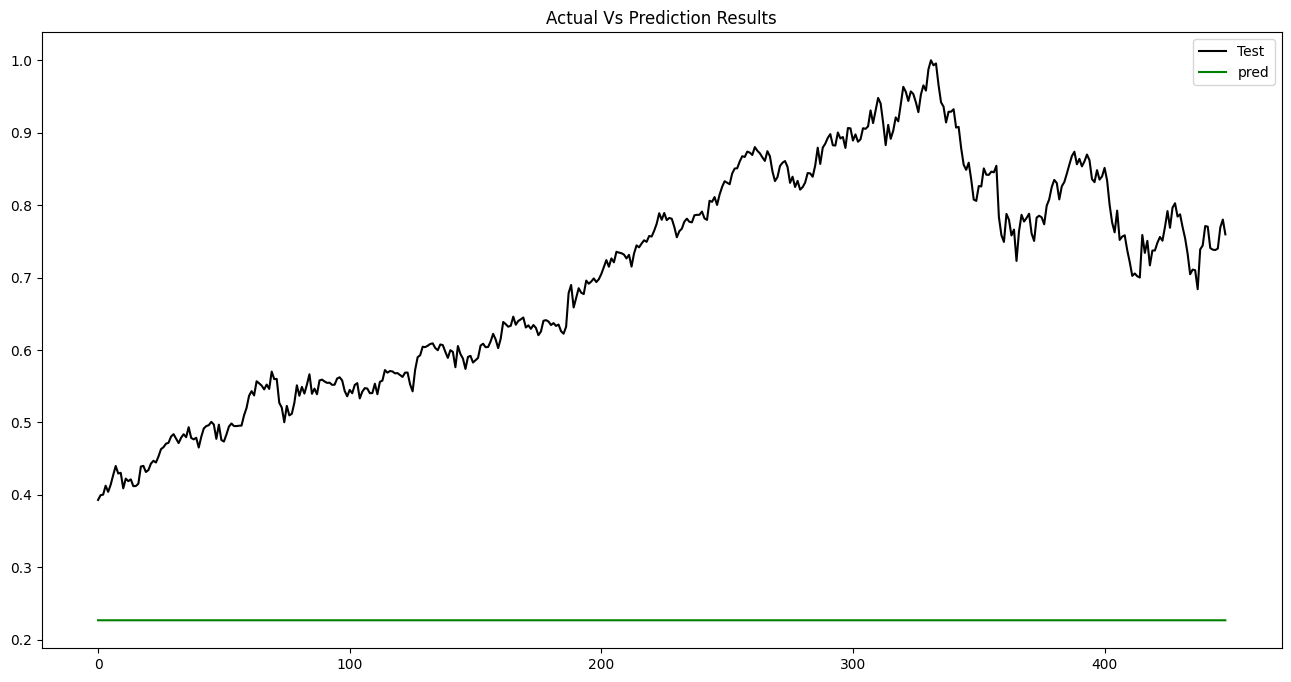

############################################################################
  Model Setup:
                    Name: MSI_F75_L1
             LSTM_Layers: 1
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: MSI
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 75
  Result Data:
             mean_abs_err =0.08115159066488596
             mean_sqr_err =0.010428197880238623
        root_mean_sqr_err =0.10211854816946148
           pred_diff_mean =0.9432365254036381
      pred_diff_bias_mean =0.05676347459636182
    pred_correctness_mean =0.7815315315315315



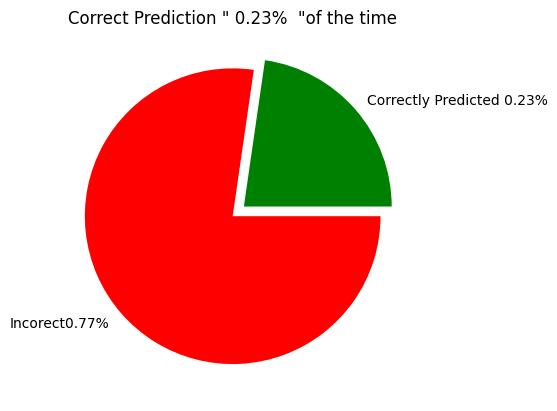

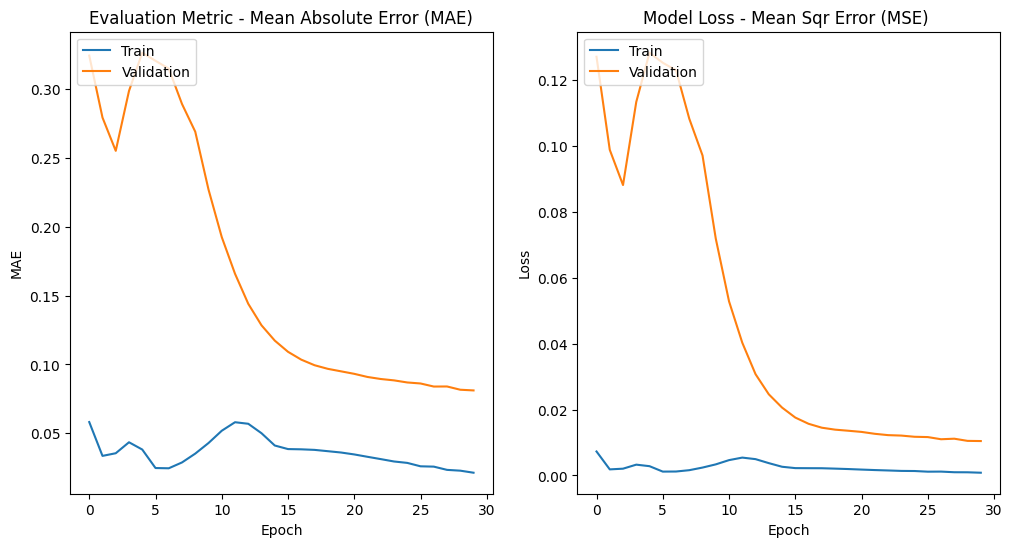

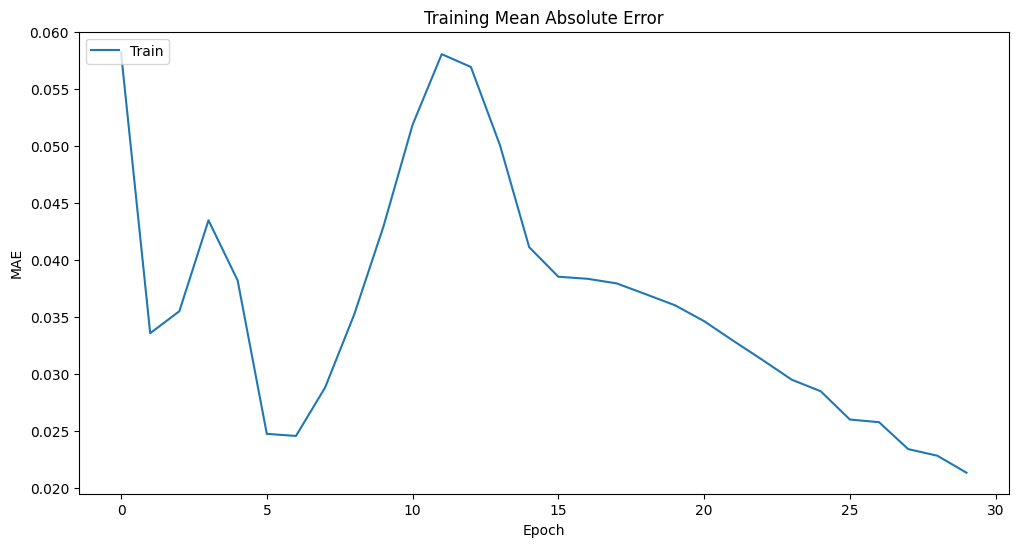

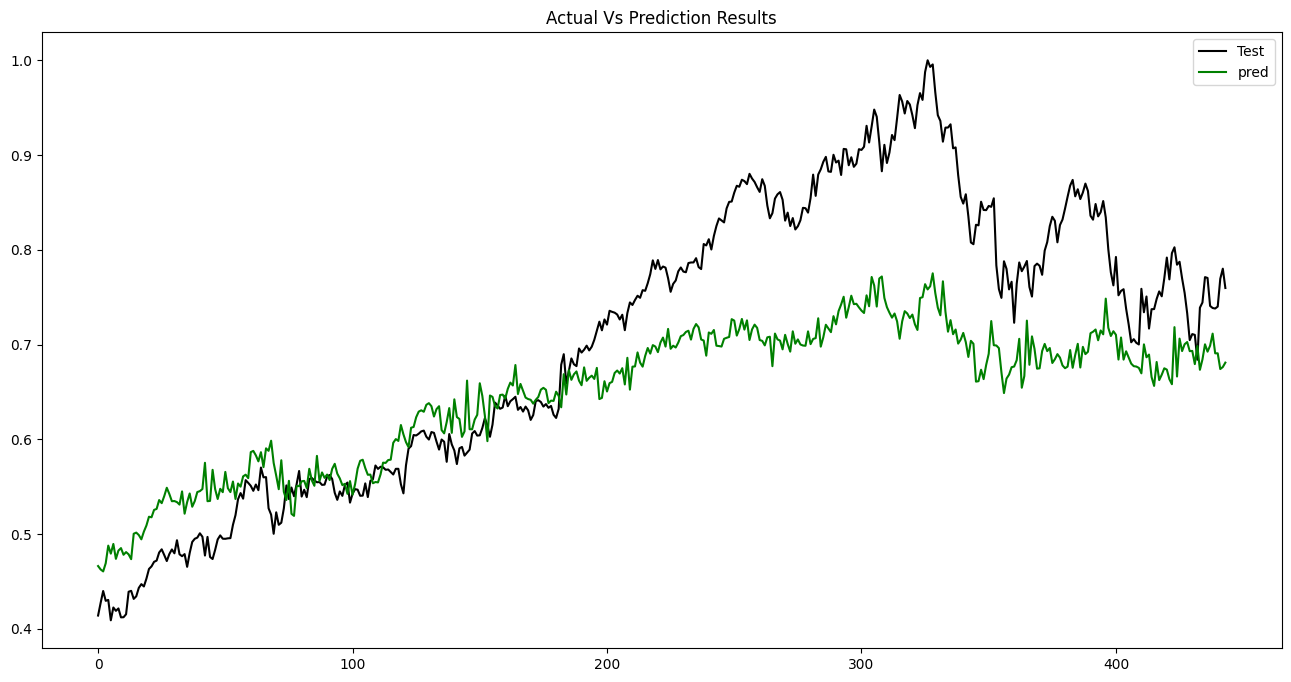

############################################################################
  Model Setup:
                    Name: MSI_F75_L2
             LSTM_Layers: 2
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: MSI
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 75
  Result Data:
             mean_abs_err =0.13348291296031867
             mean_sqr_err =0.028373754788162606
        root_mean_sqr_err =0.16844510912508742
           pred_diff_mean =0.8665231069219943
      pred_diff_bias_mean =0.13347689307800573
    pred_correctness_mean =0.722972972972973



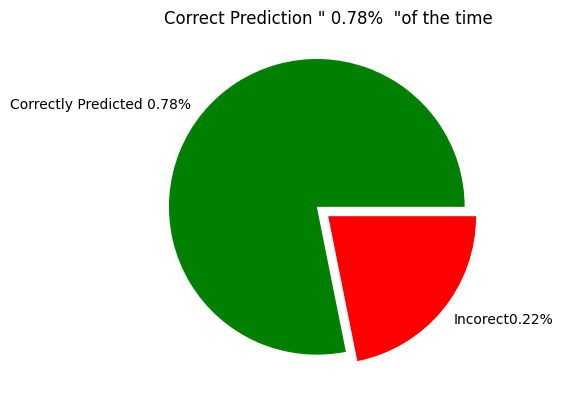

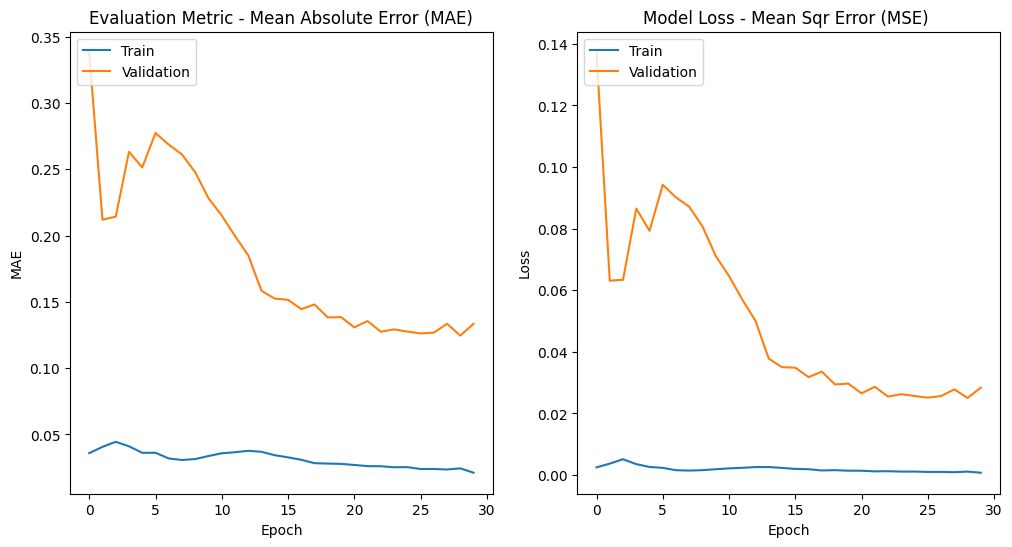

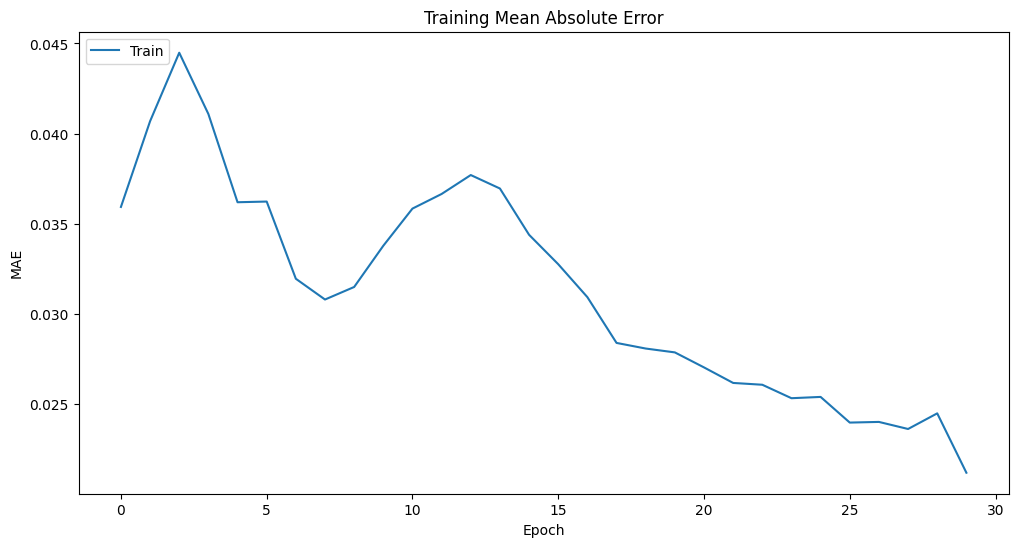

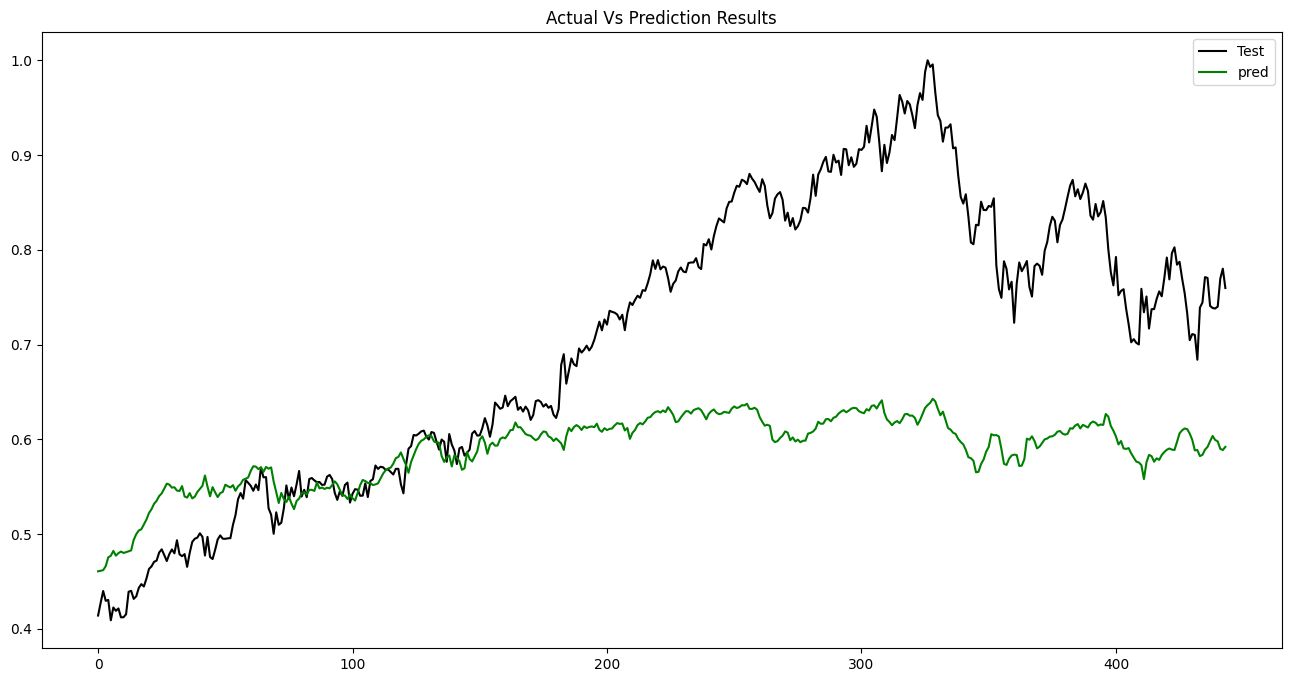

############################################################################
  Model Setup:
                    Name: MSI_F75_L3
             LSTM_Layers: 3
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: MSI
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 75
  Result Data:
             mean_abs_err =0.1428291669104698
             mean_sqr_err =0.032116997315836324
        root_mean_sqr_err =0.1792121572768888
           pred_diff_mean =0.861512941717721
      pred_diff_bias_mean =0.13848705828227909
    pred_correctness_mean =0.6666666666666666



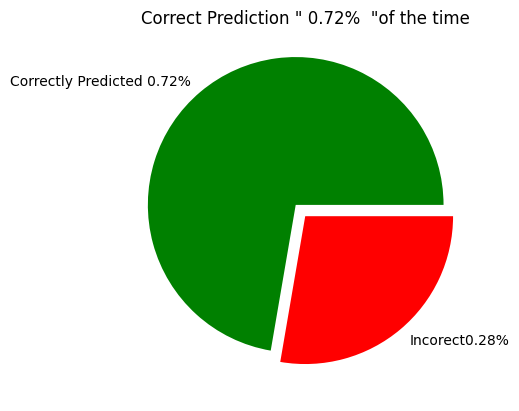

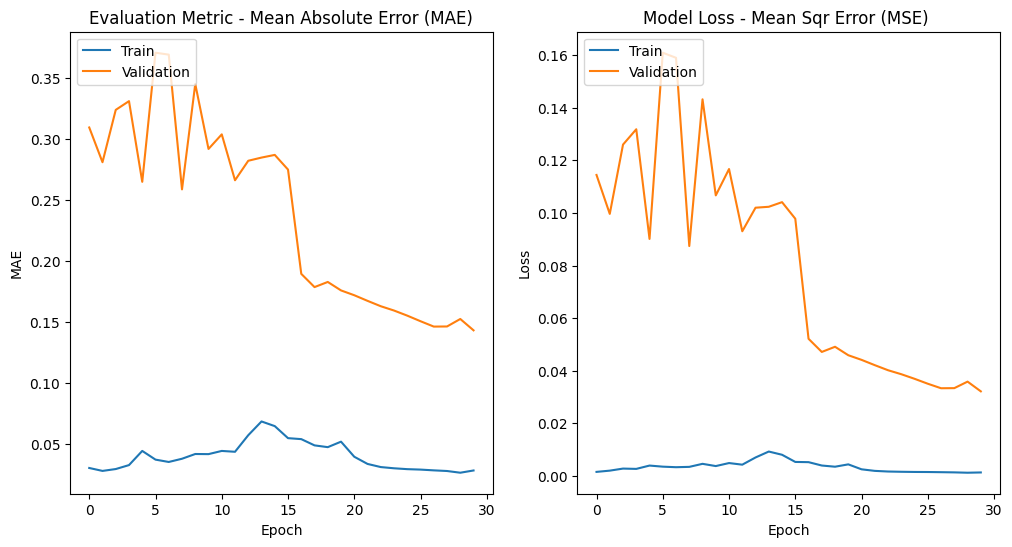

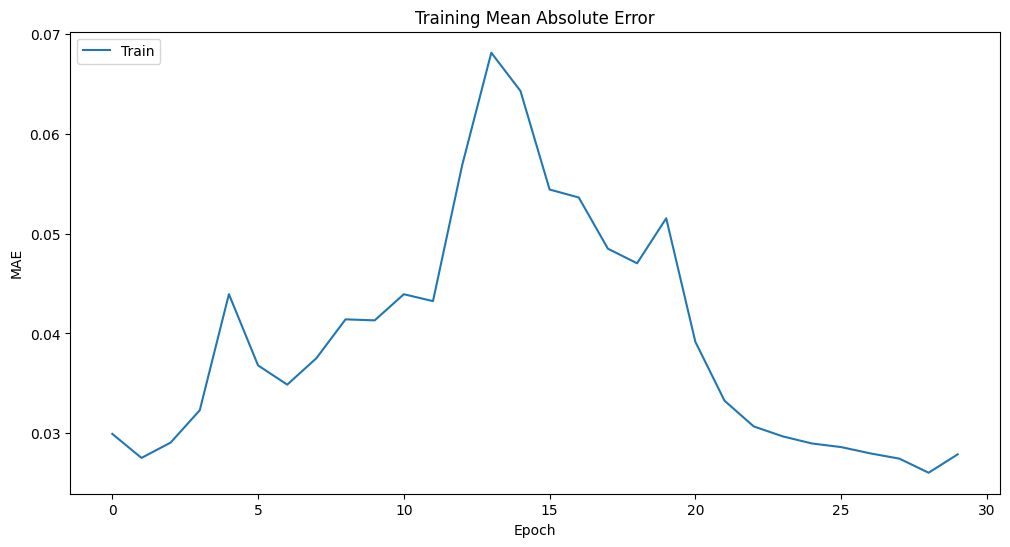

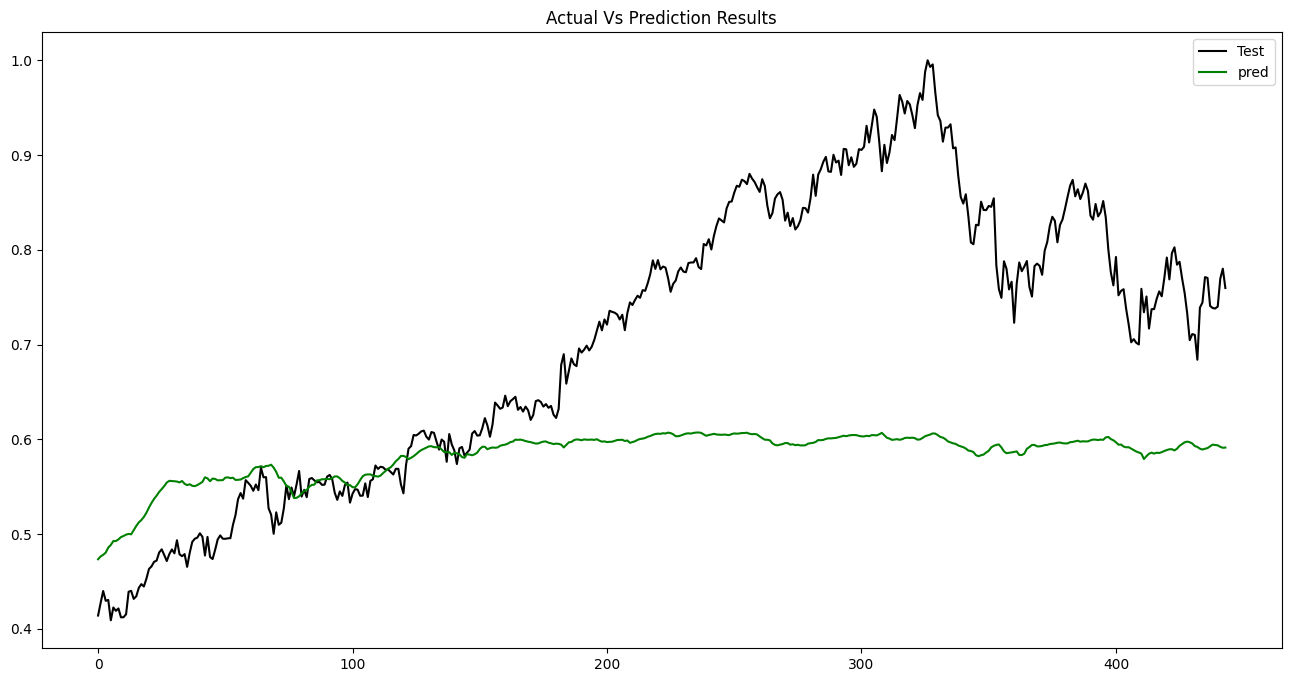

############################################################################
  Model Setup:
                    Name: MSI_F75_L4
             LSTM_Layers: 4
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: MSI
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 75
  Result Data:
             mean_abs_err =0.2527358466181462
             mean_sqr_err =0.08539932039647301
        root_mean_sqr_err =0.2922316211440388
           pred_diff_mean =0.6780634434378063
      pred_diff_bias_mean =0.32193655656219367
    pred_correctness_mean =0.40315315315315314



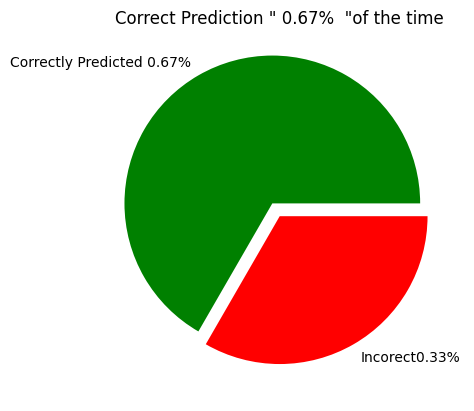

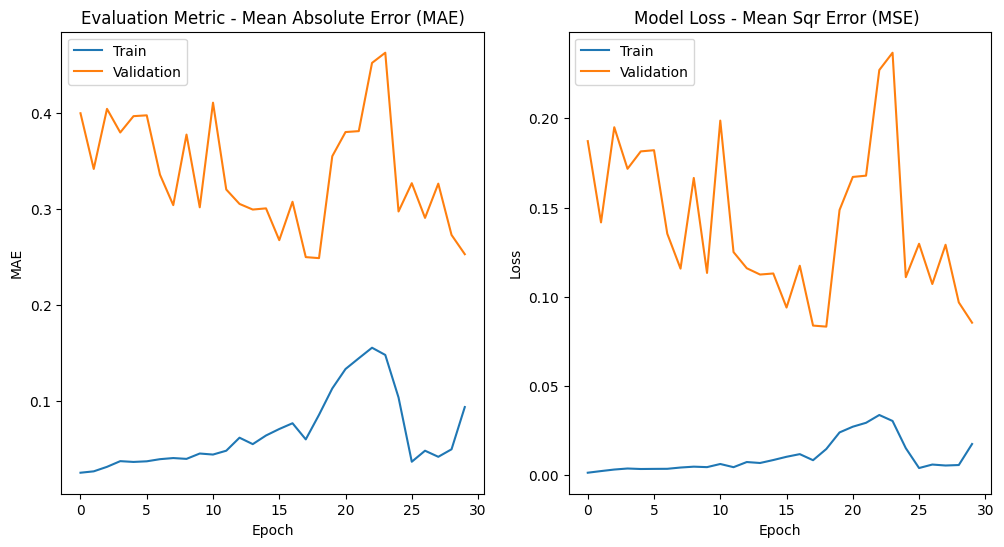

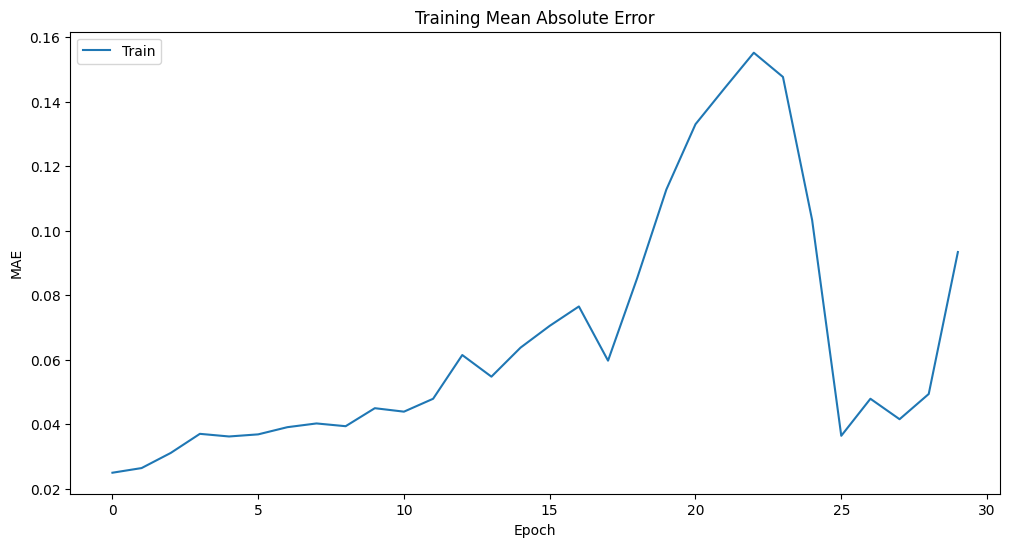

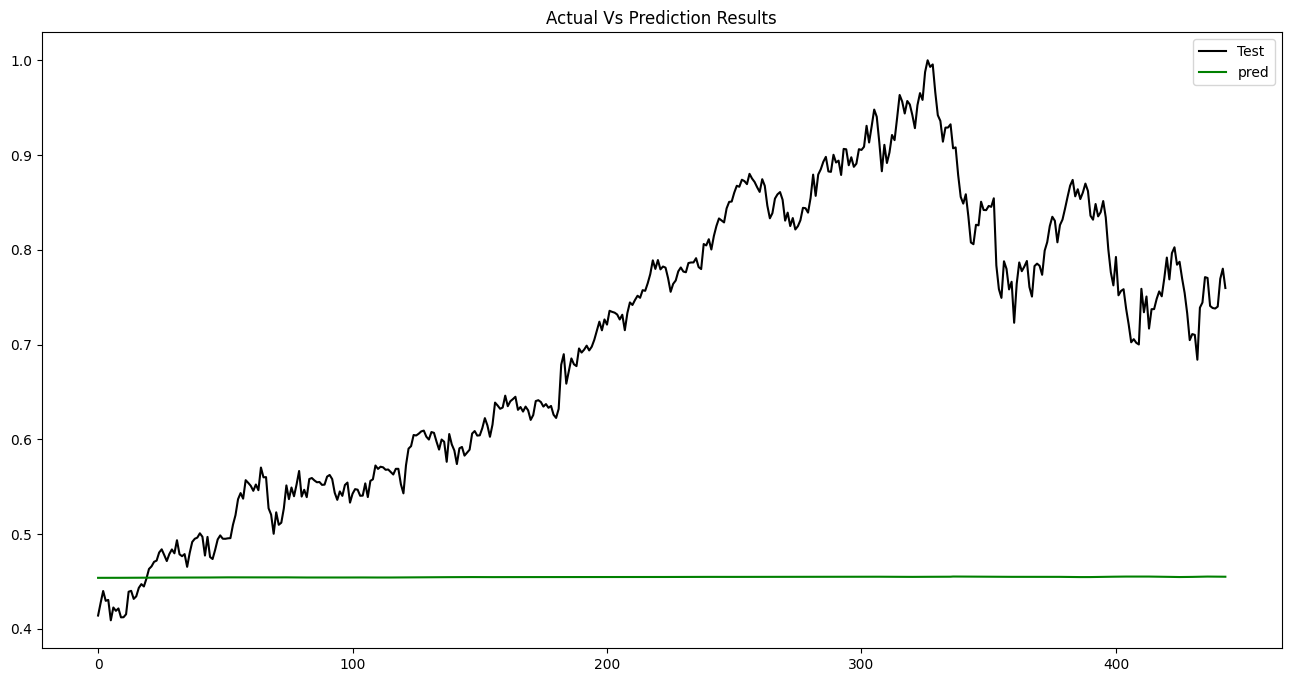

############################################################################
  Model Setup:
                    Name: MSI_F75_L5
             LSTM_Layers: 5
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: MSI
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 75
  Result Data:
             mean_abs_err =0.4683203063690329
             mean_sqr_err =0.24205077661438473
        root_mean_sqr_err =0.4919865614164524
           pred_diff_mean =0.35329356263056527
      pred_diff_bias_mean =0.6467064373694347
    pred_correctness_mean =0.23648648648648649



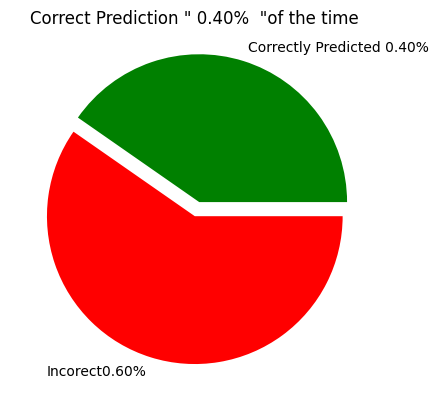

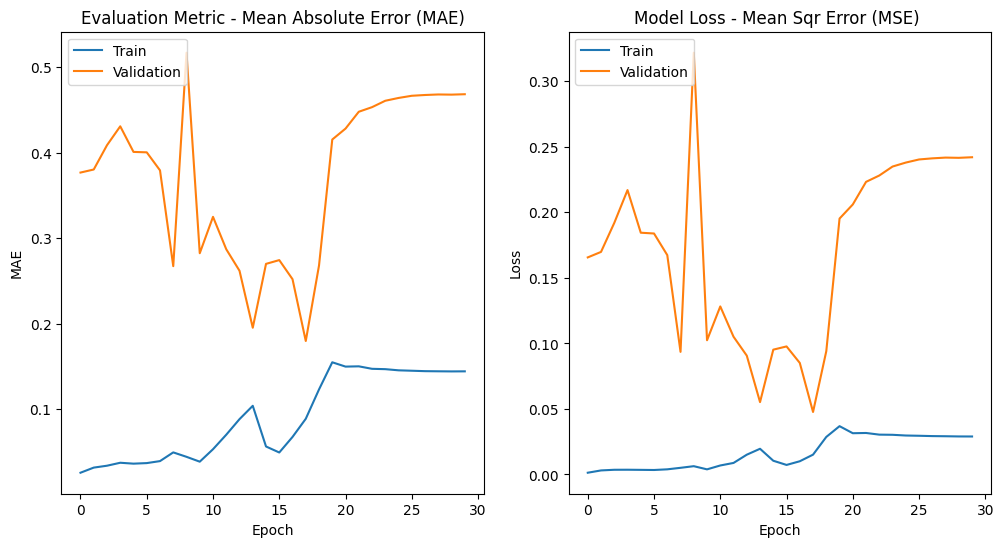

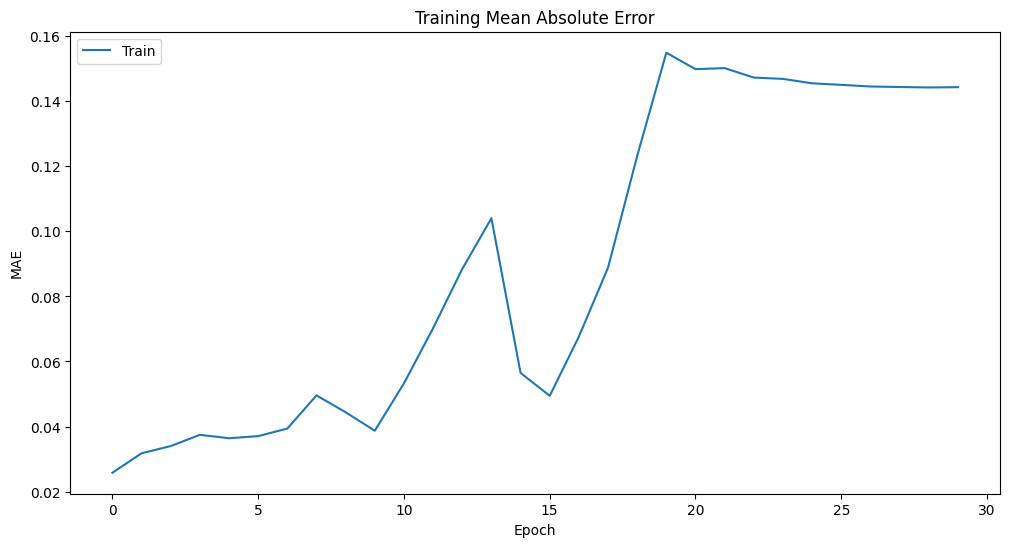

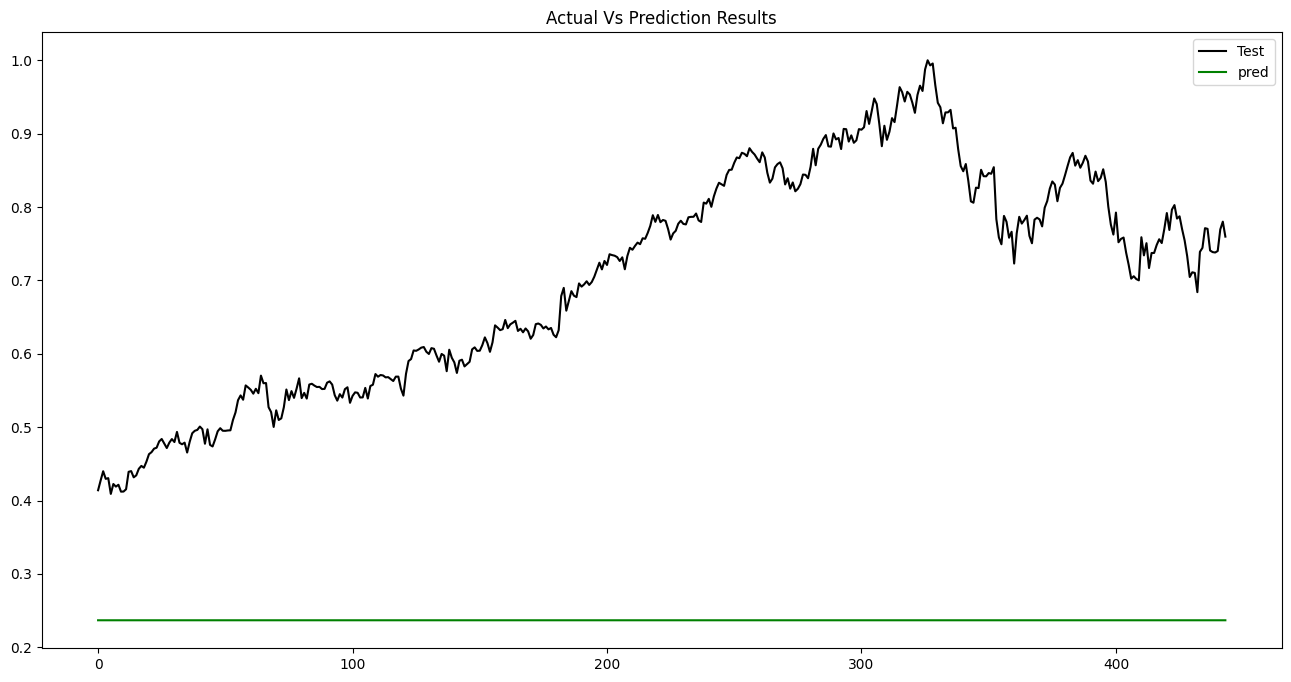

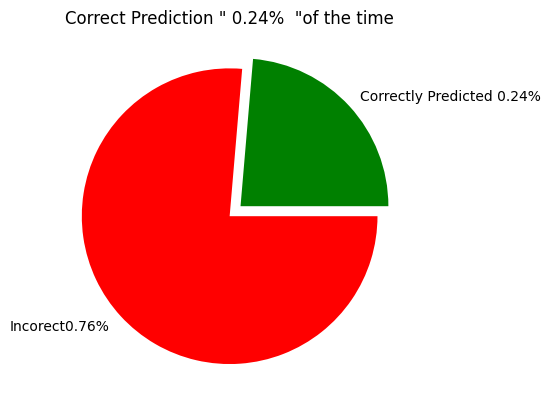

In [ ]:
for m in model_list:
  m.View_Performance_Report(show_graphs=True)


#Save Data
##Save Data to Drive

In [ ]:
#_ls '/content/drive/MyDrive/Classes/Kent/Machine Learning/Results'

##Save Best Model to drive